# Speaker-Independent Spoken Digit Recognition (xSDR)


One of the successful stories of deep neural networks is the proliferation of commercial of automatic speech recognition (ASR) systems. This project aims to explore one application of ML-powered ASR to the problem of spoken digit recognition (SDR). Since digits are widely used as unique identifiers for bank information, social security numbers, post codes, etc, SDR systems can be an efficient alternative to fully-fledged ASR systems since the domain is more predictable than other applications of ASR. 

In this project, we focus on developing a SDR system in a speaker-independent setting. That is, the speakers in the evaluation set are disjoint from the training set speakers. We do so because we expect real-world ASR systems to generalize to different speakers than those we have data for. Moreover, for many languages that are under-resourced, we have have (limited) annotated speech data from a single speaker, but we would still want the system to be deployed to work on any speaker of that language. We tackle the problem of spoken digit recognition as a sequence classification task. Concretely, the inputs are short audio clips of a specific digit (in the range 0-9), then the goal is to build deep neural network models to classify a short audio clip and predict the digit that was spoken.

# Notes

## Code Submission

You don't necessarily need to complete the code in this Jupyter Notebook, you are free to use another notebook or a python script file, as you would like. You are expected to submit the code by **22.03.2023**.

Your code should be clean and well commented. We also expect that if we decide to run it on our system, it should be straighforward to do so. We recommend creating a ```requirements.txt``` file with the names of all the libraries with their versions. If applicable, please mention the python version in a ```README.md``` file, which should also include instructions on how to run your code.

As mentioned for the assignments, always remember to cite the code with the links as comments, if you decide to use it from a public repository.

## Report Submission

With the code, you are also expected to submit a report with a maximum of 4 pages. You should write your report in LaTeX using this template for ACL 2023 [Overleaf Link](https://www.overleaf.com/latex/templates/acl-2023-proceedings-template/qjdgcrdwcnwp). Use this document to fill in any missing information that are not necessarily covered during your presentation for the sake of time in the presentation. While writing your report, we would highly encourgae you to cite the papers behind each tool / library / function that you might use for your experiments. We have also released an example on how to write equations in LaTeX [here](https://piazza.com/class/l9so16qqvk34hu/post/52).

You art also expected to submit this report with your code. You should provide the **.tex, .pdf and all image files** zipped with the same naming convention as it was in your assignment(s).

## Presentation

During the last week of March 2023, i.e. 27.03 -- 31.03, each team will be presenting their works for 15 minutes. We expect equal contribution from each member in delivery and content of the presentation. So roughly 5 minutes for one person, if you have 3 people in your team. There will be 5 minutes for some Q&A. At-least one person from your team should be present to do an in-person presentation, rest of your team could join remotely, if they are not present.

## Important Dates

 - Code & Report Submission: 22.03.2023 (08.00)
 - Presentation: 27.03.2023 -- 31.03.2023
 
 You'll get a precise date and time for your team's presentation at a later time.

### Grading

In this project, your final grades will be determined as follows:

 - **30%**: &emsp; Completing all the tasks
 - **30%**: &emsp; Providing scientific-backings for all the methods used
 - **20%**: &emsp; Quality of the content of the presentation
 - **20%**: &emsp; Delivery of the presentation

In [1]:
#%matplotlib inline
import numpy as np
import scipy, matplotlib.pyplot as plt, IPython.display as ipd
import librosa, librosa.display

import pandas as pd

from sklearn  import preprocessing
from collections import defaultdict, Counter

# add this to ignore warnings from Librosa
import warnings
warnings.filterwarnings('ignore')

import random
import os




In [2]:
# for linear models 
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

In [3]:
from sklearn.neural_network import MLPClassifier


In [4]:
import torch
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from torch.utils.data import TensorDataset, DataLoader

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn.utils import weight_norm

import itertools
from sklearn.manifold import TSNE

## Exploring the Dataset 

The speech samples are already divied into training, development, and test spilts. The splits are made in such way that evaluation speakers are not present in training split. You should use the splits as they are. 

**CAUTION:** 

In this project, you are not allowed to use any external data for this problem (at least for the main three tasks). Exploring the effect of additional datasets in this project can only included as a further step after completing the main requirements with the given data. 

In [5]:
# read tsv file into a dataframe 
sdr_df = pd.read_csv('SDR_metadata.tsv', sep='\t', header=0, index_col='Unnamed: 0')

In [6]:
sdr_df.head()

,identifier,speaker,split,label,file
0,5_theo_23,theo,TRAIN,5,speech_data/5_theo_23.wav
1,2_yweweler_39,yweweler,TEST,2,speech_data/2_yweweler_39.wav
2,6_yweweler_34,yweweler,DEV,6,speech_data/6_yweweler_34.wav
3,6_yweweler_16,yweweler,DEV,6,speech_data/6_yweweler_16.wav
4,9_yweweler_2,yweweler,TEST,9,speech_data/9_yweweler_2.wav


In [7]:
set(sdr_df.speaker.values)

{'george', 'jackson', 'lucas', 'nicolas', 'theo', 'yweweler'}

In [8]:

# explore one sample: 7_theo_0
sdr_df.loc[sdr_df['identifier'] == '7_theo_0']

,identifier,speaker,split,label,file
700,7_theo_0,theo,TRAIN,7,speech_data/7_theo_0.wav


In [9]:
sample_wav_file = sdr_df.loc[sdr_df['identifier'] == '7_theo_0'].file[700]

In [10]:
sample_wav_file

'speech_data/7_theo_0.wav'

## The Speech Waveform

The acoustic realization of speech segment can be (digitally) viewed as a time-variant wavform $\mathbf{S} \in \mathbb{R}^{n}$. Here, $n$ depends on both the duration of the speech segment and the sampling rate of the continous speech singal. Let's check out one sample from the data set. 

In [11]:
# play and listen to a sample 
SAMPLING_RATE = 8000 # This value is determined by the wav file, DO NOT CHANGE
x, sr = librosa.load(sample_wav_file, sr=SAMPLING_RATE) #, 
ipd.Audio(x, rate=sr)

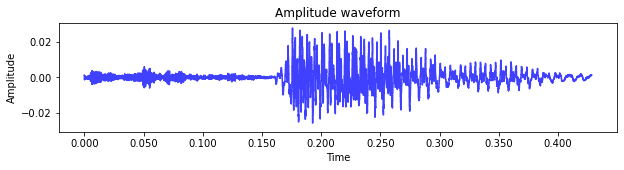

In [12]:
# plot as a waveform 
fig, ax = plt.subplots(figsize=(10, 2), sharex=True)

img = librosa.display.waveshow(y=x, sr=sr, alpha=0.75, x_axis='time', color='blue')

ax.set(title='Amplitude waveform')
ax.set_ylabel('Amplitude')
ax.label_outer()

In [13]:
# sample duration in milliseconds
(1000*len(x))/SAMPLING_RATE

428.5

In the cell above, you can see the temporal duration of the audio is 428.5 milliseconds. For digits in the range 0-9, the duration of the speech segment should be around 0.5 seconds with reasonable variation depending on speech rate (i.e., how fast the speaker speaks). 

## The Speech Signal Representation - Mel Spectrograms

Humans can recognize and differentiate different speech sounds based on the frequency characteristics of the sounds. For machine learning applications, human speech is represented using spectro-temporal features in the [Mel-scale](https://en.wikipedia.org/wiki/Mel_scale) extracted from the speech sample. Mel-scale features are inspired by human speech perception and auditory processing whereby the human ear has difference sensitivity (or resolution) in differet frequency bandes. That is, the human ear can better recognize differences in in lower range frequences, while higher range frequences have a lower resolution. The Mel-scale is linear for frequencies in the range (0-1kHz), and logarithmic for frequencies above 1kHz.

In the spectro-temporal representation of speech, a speech sample can be seen as a sequence of $T$ spectral vectors as $\mathbf{X} = (\mathbf{x}^1, \mathbf{x}^2, \dots, \mathbf{x}^T)$. Each spectral vector $\mathbf{x}^t \in \mathbb{R}^{k}$ at time-step $t$ is extracted from a short speech segment (~25 milliseconds) with the assumption that the signal is time-invariant in this small time window. Here, $k$ is the number of frequency bands in the [spectrogram](https://en.wikipedia.org/wiki/Spectrogram) and this is a parameter of the feature extraction pipeline. The representation is based on the Fourier transform to convert the temporal signal into the frequency domain. 

In automatic speech recognition (ASR) research and applications, spectral vectors are usually referred to as "acoustic frames". Morover, adjacent frames are extracted with some overlap between them, usually ~10 milliseconds. 

In [14]:
def extract_melspectrogram(signal, sr, num_mels):
    """
    Given a time series speech signal (.wav), sampling rate (sr), 
    and the number of mel coefficients, return a mel-scaled 
    representation of the signal as numpy array.
    """
    
    mel_features = librosa.feature.melspectrogram(y=signal,
        sr=sr,
        n_fft=200, # with sampling rate = 8000, this corresponds to 25 ms
        hop_length=80, # with sampling rate = 8000, this corresponds to 10 ms
        n_mels=num_mels, # number of frequency bins, use either 13 or 39
        fmin=50, # min frequency threshold
        fmax=4000 # max frequency threshold, set to SAMPLING_RATE/2
    )
    
    # for numerical stability added this line
    mel_features = np.where(mel_features == 0, np.finfo(float).eps, mel_features)

    # 20 * log10 to convert to log scale
    log_mel_features = 20*np.log10(mel_features)

    # feature scaling
    scaled_log_mel_features = preprocessing.scale(log_mel_features, axis=1)
    
    return scaled_log_mel_features

In [15]:
melspectrogram = extract_melspectrogram(x, sr, num_mels=13)
melspectrogram

array([[-1.4403375 , -1.1560788 , -1.2758843 , -1.3302561 , -1.455996  ,
        -1.2271106 , -1.3477    , -1.1566846 , -1.1540704 , -1.317029  ,
        -1.0830339 , -1.1264331 , -1.289925  , -1.291689  , -1.1598166 ,
        -1.2263535 ,  0.2289877 ,  1.0015292 ,  1.0212659 ,  1.0087676 ,
         1.0344915 ,  1.0081851 ,  0.95065796,  0.94541764,  1.024923  ,
         1.0669168 ,  1.0016327 ,  1.026864  ,  1.057682  ,  0.98052514,
         0.79963857,  0.5760491 ,  0.6717507 ,  0.7536291 ,  0.725084  ,
         0.740158  ,  0.76018435,  0.6208987 ,  0.5152995 ,  0.24102668,
         0.20198077,  0.0268851 ,  0.04796753],
       [-1.5693731 , -1.1794999 , -1.1788254 , -0.9945803 , -1.2961985 ,
        -1.4162161 , -1.177581  , -0.99777126, -1.0092193 , -1.5616904 ,
        -0.99744636, -0.93611056, -1.1575567 , -1.0355861 , -0.82686776,
        -1.0189241 ,  0.30772254,  1.0856628 ,  1.5396351 ,  1.5049155 ,
         1.4061823 ,  1.3355076 ,  1.2298043 ,  1.1036735 ,  1.1364572 ,
   

Note that the shape of the array (K x T) represents the number of frequency bands (K) and the number of spectral vectors in this representation (here, K=13, T=43). K is a hyperparameter and the recommended values in ASR research are (13, 39, 81, etc). Here, we fix K = 13. On the other hand, T varies from sample to sample depending on the duration of the sample.  

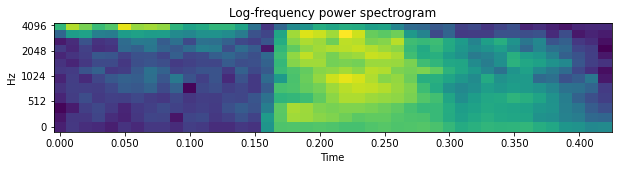

In [16]:
# plot and view the spectrogram

fig, ax = plt.subplots(figsize=(10, 2), sharex=True)

img = librosa.display.specshow(
    melspectrogram, 
    sr=sr, 
    x_axis='time', 
    y_axis='mel', 
    cmap='viridis', 
    fmax=4000, 
    hop_length=80
)

ax.set(title='Log-frequency power spectrogram')

ax.label_outer()

As you can see above from the figure, the spectrogram representation can be viewed as a matrix $\mathbf{X} \in \mathbb{R}^{T} \times \mathbb{R}^{k}$.  

## Task I
1. One problem with the spectrogram as a speech feature represetation is that different speech samples would have dfferent durations due to inherent speech variability (e.g., speech rate, speaker dialect, etc). That is, the $T$ in the $(T \times k)$-dimensional representation would be different for each sample. Therefore, for the baseline model, we will implement a method to have a fixed-size representation for all speech samples. Write a function downsample_spectrogram(X, N) that takes as input a spectrogram $\mathbf{X} \in \mathbb{R}^{T \times k}$ and a parameter N <= 25. The function should (1) make N equally-sized splits of S across the time-axis, (2) apply a pooling technique (e.g., mean pooling) to each split across the frequency axis to obtain an array that represents a downsampled version of the spectrogram $\mathbf{X}' \in \mathbb{R}^{N \times k}$, and (3) re-arange $\mathbf{X}'$ as a vector $\mathbf{v} \in \mathbb{R}^{Nk}$.    

2. Using the downsample_spectrogram(X, N) function, transform all the speech samples into vectors $\mathbf{v} \in \mathbb{R}^{Nk}$. 

3. Given the speaker-based train/dev/test spilts in the SDR_metadata.tsv, fit a linear model on the training samples. That is, your model should be build on data from 4 speakers {'nicolas', 'theo' , 'jackson',  'george'}. Hint: you can experiment with a few model alternatives in the SGDClassifier module in scikit-learn. 

4. Evaluate you model on the dev and test splits. Use accuracy as an evaluation metric. Analyze the model performance using a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) of the all possible labels (0-9), Analyze [precision, recall](https://en.wikipedia.org/wiki/Precision_and_recall), [F1-score](https://en.wikipedia.org/wiki/F-score) for each label. Report your observation.

## Baseline Model

In [17]:
def downsample_spectrogram(X, N):
    k, T = X.shape
    M = T // N
    X_downsampled = np.zeros((N,k ))

    for i in range(N):
        X_split = X[:, i*M:(i+1)*M]
        X_downsampled[i, :] = np.mean(X_split, axis=1)

    v = X_downsampled.reshape(k, N).astype(float)

    return v


In [18]:
df = pd.read_csv('SDR_metadata.tsv', sep='\t', header=0, index_col='Unnamed: 0')
SPEAKERS = {'nicolas', 'theo', 'jackson', 'george'}
train_data = df[df['split'] == 'TRAIN']
train_data= train_data[train_data['speaker'].isin(SPEAKERS)]
train_data

,identifier,speaker,split,label,file
0,5_theo_23,theo,TRAIN,5,speech_data/5_theo_23.wav
6,4_george_11,george,TRAIN,4,speech_data/4_george_11.wav
7,8_george_18,george,TRAIN,8,speech_data/8_george_18.wav
8,8_george_13,george,TRAIN,8,speech_data/8_george_13.wav
9,2_nicolas_16,nicolas,TRAIN,2,speech_data/2_nicolas_16.wav
...,...,...,...,...,...
2988,7_nicolas_38,nicolas,TRAIN,7,speech_data/7_nicolas_38.wav
2989,2_theo_5,theo,TRAIN,2,speech_data/2_theo_5.wav
2990,8_george_29,george,TRAIN,8,speech_data/8_george_29.wav
2996,1_theo_24,theo,TRAIN,1,speech_data/1_theo_24.wav


In [19]:
downsample_spectrogram(melspectrogram, 15)

array([[-1.29820824, -1.3744365 , -1.61253488, -1.24872828, -1.15347362,
        -1.24340522, -1.13429594, -1.30677485, -1.29151225, -1.24618852,
        -1.41901994, -0.09279197,  1.2014972 , -1.30307019, -1.08670282],
       [-1.00433004, -1.01307344, -1.09100413, -1.14931357, -0.700441  ,
        -1.03920555, -0.91356844, -1.15730405, -1.01307368,  0.14182295,
         1.06214368, -1.34155333, -1.35620737, -1.25946927, -1.06108952],
       [-0.81231391, -0.66905463, -1.13086808, -1.03441083, -0.90014553,
        -0.84952277, -0.78761774,  0.08512487,  1.49080431, -1.25219226,
        -1.08767605, -1.10495591, -1.024279  , -0.64926952, -0.51752555],
       [-0.52999651, -0.81421137, -0.81806874, -0.43992501, -0.20980451,
         0.38499504,  1.50711679, -1.23554969, -1.28545487, -0.96520734,
        -1.06414819, -0.75656754, -0.48631352, -0.79764211, -0.99345982],
       [-0.81002593, -0.64683026, -0.52124715,  0.20611912,  1.07834458,
        -1.10473347, -0.96677846, -1.08586097, 

In [20]:
def load_data(filepath):
    # Load the data into a pandas dataframe
    df = pd.read_csv(filepath, sep='\t')
    SPEAKERS = {'nicolas', 'theo', 'jackson', 'george'}
    
    # Split the data into train, dev, and test sets
    train_data = df[df['split'] == 'TRAIN']
    train_data= train_data[train_data['speaker'].isin(SPEAKERS)]
    dev_data = df[df['split'] == 'DEV']
    test_data = df[df['split'] == 'TEST']
    
    # Extract the X and y data for each split
    X_train = []
    y_train = []
    for x in train_data['file'].tolist():
        X = extract_melspectrogram(librosa.load(x)[0],sr=8000, num_mels=13)
        X_train.append(X)
        y_train.append(train_data.loc[train_data['file'] == x, 'label'].iloc[0])
    
    X_dev = []
    y_dev = []
    for x in dev_data['file'].tolist():
        X = extract_melspectrogram(librosa.load(x)[0],sr=8000, num_mels=13)
        X_dev.append(X)
        y_dev.append(dev_data.loc[dev_data['file'] == x, 'label'].iloc[0])
    
    X_test = []
    y_test = []
    for x in test_data['file'].tolist():
        X = extract_melspectrogram(librosa.load(x)[0],sr=8000, num_mels=13)
        X_test.append(X)
        y_test.append(test_data.loc[test_data['file'] == x, 'label'].iloc[0])
    
    # Return the data as a tuple of lists
    return X_train, y_train, X_dev, y_dev, X_test, y_test


In [21]:
X_train, y_train, X_dev, y_dev, X_test, y_test = load_data('SDR_metadata.tsv')

In [22]:
N = 10  # Desired length of the downsampled representation

X_train_downsampled = np.array([downsample_spectrogram(X, N) for X in X_train])
max_length = max([len(X) for X in X_train_downsampled])
X_train_downsampled_padded = np.zeros((len(X_train), max_length*N))
for i, x in enumerate(X_train_downsampled):
    x_padded = np.pad(x, ((0, max_length - len(x)), (0, 0)), mode='constant')
    X_train_downsampled_padded[i, :] = x_padded.reshape(-1)

X_dev_downsampled = np.array([downsample_spectrogram(X, N) for X in X_dev])
X_dev_downsampled_padded = np.zeros((len(X_dev), max_length*N))
for i, x in enumerate(X_dev_downsampled):
    x_padded = np.pad(x, ((0, max_length - len(x)), (0, 0)), mode='constant')
    X_dev_downsampled_padded[i, :] = x_padded.reshape(-1)

X_test_downsampled = np.array([downsample_spectrogram(X, N) for X in X_test])
X_test_downsampled_padded = np.zeros((len(X_test), max_length*N))
for i, x in enumerate(X_test_downsampled):
    x_padded = np.pad(x, ((0, max_length - len(x)), (0, 0)), mode='constant')
    X_test_downsampled_padded[i, :] = x_padded.reshape(-1)

# Convert data types
X_train_downsampled_padded = X_train_downsampled_padded.astype(np.float64)
X_dev_downsampled_padded = X_dev_downsampled_padded.astype(np.float64)
X_test_downsampled_padded = X_test_downsampled_padded.astype(np.float64)
y_train = np.array([y_train])
y_train = y_train.ravel()
y_train_1 = y_train.astype(np.float64)

y_dev = np.array([y_dev])
y_dev = y_dev.ravel()
y_dev_1 = y_dev.astype(np.float64)

y_test = np.array([y_test])
y_test = y_test.ravel()
y_test_1 = y_test.astype(np.float64)

In [23]:

# Create a linear model using scikit-learn's SGDClassifier
model = SGDClassifier(loss='log', max_iter=1000, random_state=42)

# Fit the model on the training samples
model.fit(X_train_downsampled_padded,y_train_1)

SGDClassifier(loss='log', random_state=42)

In [24]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Evaluate the model on the dev and test splits
y_dev_pred = model.predict(X_dev_downsampled_padded)
y_test_pred = model.predict(X_test_downsampled_padded)

dev_accuracy = accuracy_score(y_dev_1, y_dev_pred)
test_accuracy = accuracy_score(y_test_1, y_test_pred)

dev_confusion_matrix = confusion_matrix(y_dev_1, y_dev_pred)
test_confusion_matrix = confusion_matrix(y_test_1, y_test_pred)

dev_classification_report = classification_report(y_dev_1, y_dev_pred)
test_classification_report = classification_report(y_test_1, y_test_pred)

print(f"Dev accuracy: {dev_accuracy:.3f}")
print(f"Test accuracy: {test_accuracy:.3f}")
print(f"Dev confusion matrix:\n{dev_confusion_matrix}")
print(f"Test confusion matrix:\n{test_confusion_matrix}")
print(f"Dev classification report:\n{dev_classification_report}")
print(f"Test classification report:\n{test_classification_report}")

Dev accuracy: 0.376
Test accuracy: 0.419
Dev confusion matrix:
[[38  0  2  0  0  0  2  1  0  4]
 [ 0 21  0  0  2  2 11  1  4  4]
 [15  0  5  0  2  0 16  5  3  0]
 [ 0  0  0 15  0  1 25  5  3  5]
 [32  1  1  0 13  0  4  2  1  0]
 [ 0  1  0  1  0  3 41  2  2  0]
 [ 0  3  0  2  0  0 27  6  8  8]
 [ 2  0  1  0  0  0 19 28  2  1]
 [ 0  0  0  1  0  0 25  2 13  3]
 [ 0  1  0  0  0 10 13  1  1 24]]
Test confusion matrix:
[[43  1  0  0  0  0  3  4  1  1]
 [ 0 38  0  0  1  0  9  2  4  1]
 [13  1  8  0  1  0 15 14  2  0]
 [ 0  1  0 12  0  0 17  6  1  9]
 [19  3  0  0  7  0  7  8  2  0]
 [ 0  2  0  0  0  9 33  5  0  1]
 [ 1  0  1  0  0  0 26  6  7  5]
 [ 2  2  1  0  0  1  7 28  6  0]
 [ 0  0  0  0  0  3 25  4 18  6]
 [ 0  0  0  0  0  3 13 10  2 22]]
Dev classification report:
              precision    recall  f1-score   support

         0.0       0.44      0.81      0.57        47
         1.0       0.78      0.47      0.58        45
         2.0       0.56      0.11      0.18        46
        

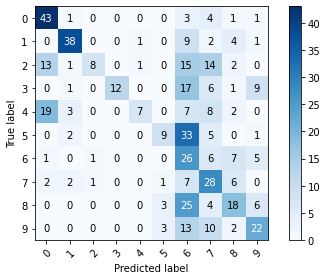

In [25]:
# Plot confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(test_confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(test_confusion_matrix.shape[1]),
       yticks=np.arange(test_confusion_matrix.shape[0]),
       xticklabels=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'],
       yticklabels=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'],
       xlabel='Predicted label',
       ylabel='True label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
fmt = 'd'
thresh = test_confusion_matrix.max() / 2.
for i in range(test_confusion_matrix.shape[0]):
    for j in range(test_confusion_matrix.shape[1]):
        ax.text(j, i, format(test_confusion_matrix[i, j], fmt),
                ha="center", va="center",
                color="white" if test_confusion_matrix[i, j] > thresh else "black")
fig.tight_layout()
plt.show()

In the baseline model, we got a Dev accuracy of 0.342 and Test accuracy of 0.386. 
When we look at the Classification report, we can see that the precision, recall and f1-score is highest for 1, 0 and 0 repectively.


## Task II
1. Having established a baseline with a linear model trained on a downsampled signal representation of the speech segment, this task aims to learn a classifier based on the full speech segment. To this end, you will implement a neural model that is suitable for sequential data such as recurrent DNN, convolutional DNN with 1-D temporal convolution, or an audio transformer. The model should take the acoustic sample as it is (i.e., the Mel spectrogram could have an arbitrary length) without the need to downsample the segment. You need to implement at least two of the aforementioned models. Do the neural models improve accuracy over the baseline model? Do you observe any signs of overfitting to the training data? How do the hyperparameters affect the model performance? Report and discuss your observations.        

2. Evaluate your (best) neural models and compare to the baseline model using the same evalution process as in task I.4. 

3. Use a dimensionality reduction algorithm such as t-SNE \[[1](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding),[2](https://pypi.org/project/tsne-torch/),[3](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)\] or [UMAP](https://umap-learn.readthedocs.io/en/latest/basic_usage.html) to analyze how the different models seperate the different classes (the last non-linear layer in your model). Compare to the downsampled representation you used in the baseline and report your observations.

4. Are the differences between the different models statistically significant? To answer this question, you need to implement a statistical significance test based on bootstrapping method. To read more how to estiame p-values based on bootstrapping, we recommend the materials on this paper https://aclanthology.org/D12-1091.pdf. Include the baseline model in your evaluation. 

In [26]:
# Load metadata
sdr_df = pd.read_csv('SDR_metadata.tsv', sep='\t', header=0, index_col='Unnamed: 0')

# Load data for each audio file, downsample and extract mel-spectrogram features
def load_downsample_melspec(audio_file, sr=8000, num_mels=13, hop_length=80):
    signal, _ = librosa.load(audio_file, sr=sr)
    mel_features = extract_melspectrogram(signal,sr=8000, num_mels=13)
    return mel_features


max_length = 0
for _, row in sdr_df.iterrows():
    mel_spec = load_downsample_melspec(row['file'])
    if mel_spec.shape[1] > max_length:
        max_length = mel_spec.shape[1]

# Load data and labels for all files in the metadata
X = []
y = []
for _, row in sdr_df.iterrows():
    mel_features = load_downsample_melspec(row['file'])
    padded_mel_features = np.pad(mel_features, ((0, 0), (0, max_length - mel_features.shape[1])), mode='constant')
    X.append(padded_mel_features)
    y.append(row['label'])

# Split data into train, dev, and test sets
train_indices = sdr_df[sdr_df['split'] == 'TRAIN'].index
dev_indices = sdr_df[sdr_df['split'] == 'DEV'].index
test_indices = sdr_df[sdr_df['split'] == 'TEST'].index

X_train = [X[i] for i in train_indices]
y_train = [y[i] for i in train_indices]

X_dev = [X[i] for i in dev_indices]
y_dev = [y[i] for i in dev_indices]

X_test = [X[i] for i in test_indices]
y_test = [y[i] for i in test_indices]
# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)

X_dev = torch.tensor(X_dev, dtype=torch.float32)
y_dev = torch.tensor(y_dev, dtype=torch.long)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)




In [27]:
#function to load data for RNN and TCN
def loader(X_train,y_train,X_dev,y_dev,X_test,y_test):
    batch_size=32
# Create data loader objects
    train_data = TensorDataset(X_train, y_train)
    dev_data = TensorDataset(X_dev, y_dev)
    test_data = TensorDataset(X_test, y_test)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    return train_loader,dev_loader,test_loader

In [28]:
train_loader,dev_loader,test_loader=loader(X_train,y_train,X_dev,y_dev,X_test,y_test)


In [29]:
# Defining input size and output size
input_size = X_train.shape[2]
output_size = len(torch.unique(y_train))


TCN MODEL: Convolutional DNN with 1-D temporal convolution

In [30]:
import torch.nn as nn
from torch.nn.utils import weight_norm

class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size, dropout):
        super(TCN, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.num_channels = num_channels
        self.kernel_size = kernel_size
        self.dropout = dropout
        
        self.conv_layers = self.create_conv_layers()
        self.fc_layer = nn.Linear(num_channels[-1], output_size)

    def create_conv_layers(self):
        layers = []
        input_channels = self.input_size
        for num_channels in self.num_channels:
            layers += [weight_norm(nn.Conv1d(input_channels, num_channels, self.kernel_size, stride=1, dilation=1, padding=(self.kernel_size-1)//2))]
            layers += [nn.BatchNorm1d(num_channels)]
            layers += [nn.ReLU()]
            layers += [nn.Dropout(p=self.dropout)]
            input_channels = num_channels
        return nn.Sequential(*layers)

    def forward(self, x,use_lastlayer=False):
        # input shape: (batch_size, input_size, sequence_length)
        x = x.permute(0, 2, 1) # shape: (batch_size, sequence_length, input_size)
        out = self.conv_layers(x)
        out = out.max(dim=-1)[0] # global max pooling
        out = self.fc_layer(out)
        if use_lastlayer==True:
            out = torch.softmax(out,dim=1)
        return out


RNN MODEL: Recurrent DNN

In [31]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x,use_lastlayer=False):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate RNN
        out, _ = self.rnn(x, h0)
        # Decode hidden state of last time step
        out = self.fc(out[:, -1, :])
        if use_lastlayer==True:
            out = torch.softmax(out,dim=1)
            
            
        return out



In [32]:
def train_model(model,train_loader,n_epochs,learning_rate):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(n_epochs):
        # Train for one epoch
        model.train()
        train_loss = 0.0
        train_acc = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * data.size(0)
            train_acc += (output.argmax(1) == target).sum().item()
        train_loss /= len(train_loader.dataset)
        train_acc /= len(train_loader.dataset)


        print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.3f}Train Acc: {train_acc:.3f}")



In [33]:
def test(model,test_loader):
    criterion = nn.CrossEntropyLoss()
    model.eval()
    tcn_test_preds = []
    tcn_test_targets = []
    tcn_test_loss = 0.0
    tcn_test_acc = 0.0
    max_tcn_test_acc=0.0
    with torch.no_grad():
        for data, target in test_loader:
            tcn_test_output = model(data)
            preds = tcn_test_output.argmax(1)
            tcn_test_preds.extend(preds.cpu().numpy())
            tcn_test_targets.extend(target.cpu().numpy())
            tcn_test_loss = criterion(tcn_test_output, target)
            tcn_test_loss += tcn_test_loss.item() * data.size(0)
            tcn_test_acc += (tcn_test_output.argmax(1) == target).sum().item()
             
              
    tcn_test_loss /= len(test_loader.dataset)
    tcn_test_acc /= len(test_loader.dataset)
    test_cm = confusion_matrix(tcn_test_targets,tcn_test_preds)
    test_cr = classification_report(tcn_test_targets, tcn_test_preds)

    if tcn_test_acc > max_tcn_test_acc:
         max_tcn_test_acc = tcn_test_acc
    print(f"Test Loss: {tcn_test_loss:.3f}, Test Acc: {max_tcn_test_acc:.3f}")
    print(f"Test confusion matrix:\n{test_cm}")
    print(f"Test classification report:\n{test_cr}")
    return test_cr
    



In [34]:
def dev(model,dev_loader,flag=0):

    
#Evaluate on dev set
        model.eval()
        criterion = nn.CrossEntropyLoss()
        tcn_dev_preds = []
        tcn_dev_targets = []
        tcn_dev_loss = 0.0
        tcn_dev_acc = 0.0
        max_tcn_dev_acc=0
        with torch.no_grad():
            for data, target in dev_loader:

                output = model(data)
                preds = output.argmax(1)
                tcn_dev_preds.extend(preds.cpu().numpy())
                tcn_dev_targets.extend(target.cpu().numpy())
                loss = criterion(output, target)

                tcn_dev_loss += loss.item() * data.size(0)
                tcn_dev_acc += (output.argmax(1) == target).sum().item()
        tcn_dev_loss /= len(dev_loader.dataset)
        tcn_dev_acc /= len(dev_loader.dataset)
      
        if flag==1:
            dev_cm = confusion_matrix(tcn_dev_targets,tcn_dev_preds)
            dev_cr = classification_report(tcn_dev_targets, tcn_dev_preds)
            print(f"Dev confusion matrix:\n{dev_cm}")
            print(f"Dev classification report:\n{dev_cr}")
            return tcn_dev_acc
        else:
            return tcn_dev_acc
            
            
        
    

RNN AND TCN: Training using best parameters

In [35]:
def best_param1( train_loader, dev_loader, test_loader, 
                input_size, output_size, num_layers, dropout_rate, 
                hidden_size_range, learning_rate_range, num_epochs_range,model=None):
  
    # Use grid search or random search to try different combinations of hyperparameters
    if (model!=None):
        param_grid = itertools.product(hidden_size_range, learning_rate_range, num_epochs_range,num_layers,dropout_rate)
    else:
        param_grid = itertools.product(learning_rate_range, num_epochs_range,dropout_rate)
        
    param_grid = list(param_grid)
    random.shuffle(param_grid)
    model1=model
    best_params = None
    best_dev_acc = 0.0
    criterion = nn.CrossEntropyLoss()

    for i, params in enumerate(param_grid):
        # Unpack hyperparameters
        if (model1!=None):
            hidden_size, learning_rate, num_epochs, num_layers,dropout_rate = params
        else:
            learning_rate,num_epochs,dropout_rate=params
            
            
        

        # Create model and optimizer
        if (model1=="rnn"):
            model = RNNModel(input_size, hidden_size, num_layers, output_size, dropout_rate)
        else:
            model = TCN(input_size, output_size, num_channels=[64, 64, 64], kernel_size=3,dropout=dropout_rate)
            
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        # Train model and evaluate on validation set
        train_model(model,train_loader,num_epochs,learning_rate)
        dev_acc=dev(model,dev_loader,flag=0)
        if dev_acc > best_dev_acc:
            best_params = params
            best_dev_acc = dev_acc

        print(f"Finished {i+1} of {len(param_grid)} parameter combinations")
        print("best parameters are",best_params)
        print("dev accuracy for the given set of parameters", dev_acc)
        
       
    # Train the final model using the best hyperparameters on the combined training and validation sets
    if(model1!=None):
        hidden_size, learning_rate, num_epochs,num_layers,dropout_rate = best_params
    else:
        learning_rate,num_epochs,dropout_rate=best_params
    print("best dev accuracy",best_dev_acc)
        
        
    
    if (model1=="rnn"):
        model_rnn = RNNModel(input_size, hidden_size, num_layers, output_size, dropout_rate)
        train_model(model_rnn,train_loader,num_epochs,learning_rate)
        t=test(model_rnn,test_loader)
        dev(model_rnn,dev_loader,flag=1)
        
    else:
        model_TCN = TCN(input_size, output_size, num_channels=[64, 64, 64], kernel_size=3,dropout=dropout_rate)
        train_model(model_TCN,train_loader,num_epochs,learning_rate)
        t=test(model_TCN,test_loader)
        dev(model_TCN,dev_loader,flag=1)

    if(model1!=None):
        return model_rnn
    else:
        return model_TCN

In [36]:

model_rnn=best_param1(train_loader=train_loader, dev_loader=dev_loader, test_loader=test_loader, 
            input_size=X_train.shape[2],output_size = len(torch.unique(y_train)), num_layers=[2,10,20], dropout_rate=[0.2,0.5],
            hidden_size_range=[20, 50,32,64], learning_rate_range=[0.01, 0.001], num_epochs_range=[10, 20,50],model="rnn")



Epoch 1/10, Train Loss: 1.713Train Acc: 0.423
Epoch 2/10, Train Loss: 1.271Train Acc: 0.594
Epoch 3/10, Train Loss: 1.085Train Acc: 0.661
Epoch 4/10, Train Loss: 1.193Train Acc: 0.616
Epoch 5/10, Train Loss: 1.131Train Acc: 0.633
Epoch 6/10, Train Loss: 1.252Train Acc: 0.581
Epoch 7/10, Train Loss: 1.099Train Acc: 0.644
Epoch 8/10, Train Loss: 1.091Train Acc: 0.641
Epoch 9/10, Train Loss: 1.088Train Acc: 0.645
Epoch 10/10, Train Loss: 1.145Train Acc: 0.613
Finished 1 of 144 parameter combinations
best parameters are (50, 0.01, 10, 2, 0.5)
dev accuracy for the given set of parameters 0.24346076458752516
Epoch 1/10, Train Loss: 2.235Train Acc: 0.186
Epoch 2/10, Train Loss: 1.887Train Acc: 0.321
Epoch 3/10, Train Loss: 2.010Train Acc: 0.258
Epoch 4/10, Train Loss: 1.938Train Acc: 0.282
Epoch 5/10, Train Loss: 1.954Train Acc: 0.265
Epoch 6/10, Train Loss: 1.861Train Acc: 0.315
Epoch 7/10, Train Loss: 1.772Train Acc: 0.367
Epoch 8/10, Train Loss: 1.766Train Acc: 0.364
Epoch 9/10, Train Loss

Epoch 15/50, Train Loss: 0.476Train Acc: 0.846
Epoch 16/50, Train Loss: 0.454Train Acc: 0.860
Epoch 17/50, Train Loss: 0.457Train Acc: 0.857
Epoch 18/50, Train Loss: 0.434Train Acc: 0.855
Epoch 19/50, Train Loss: 0.424Train Acc: 0.858
Epoch 20/50, Train Loss: 0.377Train Acc: 0.881
Epoch 21/50, Train Loss: 0.365Train Acc: 0.885
Epoch 22/50, Train Loss: 0.325Train Acc: 0.902
Epoch 23/50, Train Loss: 0.361Train Acc: 0.879
Epoch 24/50, Train Loss: 0.295Train Acc: 0.902
Epoch 25/50, Train Loss: 0.322Train Acc: 0.895
Epoch 26/50, Train Loss: 0.341Train Acc: 0.895
Epoch 27/50, Train Loss: 0.311Train Acc: 0.903
Epoch 28/50, Train Loss: 0.260Train Acc: 0.919
Epoch 29/50, Train Loss: 0.274Train Acc: 0.913
Epoch 30/50, Train Loss: 0.242Train Acc: 0.924
Epoch 31/50, Train Loss: 0.260Train Acc: 0.917
Epoch 32/50, Train Loss: 0.236Train Acc: 0.923
Epoch 33/50, Train Loss: 0.248Train Acc: 0.922
Epoch 34/50, Train Loss: 0.271Train Acc: 0.916
Epoch 35/50, Train Loss: 0.215Train Acc: 0.929
Epoch 36/50, 

Epoch 42/50, Train Loss: 0.836Train Acc: 0.734
Epoch 43/50, Train Loss: 0.865Train Acc: 0.715
Epoch 44/50, Train Loss: 0.836Train Acc: 0.726
Epoch 45/50, Train Loss: 0.821Train Acc: 0.733
Epoch 46/50, Train Loss: 0.810Train Acc: 0.749
Epoch 47/50, Train Loss: 0.798Train Acc: 0.739
Epoch 48/50, Train Loss: 0.794Train Acc: 0.750
Epoch 49/50, Train Loss: 0.831Train Acc: 0.733
Epoch 50/50, Train Loss: 0.816Train Acc: 0.736
Finished 14 of 144 parameter combinations
best parameters are (32, 0.001, 50, 2, 0.2)
dev accuracy for the given set of parameters 0.3299798792756539
Epoch 1/20, Train Loss: 2.331Train Acc: 0.105
Epoch 2/20, Train Loss: 2.325Train Acc: 0.104
Epoch 3/20, Train Loss: 2.255Train Acc: 0.156
Epoch 4/20, Train Loss: 2.248Train Acc: 0.156
Epoch 5/20, Train Loss: 2.220Train Acc: 0.166
Epoch 6/20, Train Loss: 2.227Train Acc: 0.163
Epoch 7/20, Train Loss: 2.208Train Acc: 0.169
Epoch 8/20, Train Loss: 2.226Train Acc: 0.152
Epoch 9/20, Train Loss: 2.143Train Acc: 0.203
Epoch 10/20, 

Epoch 39/50, Train Loss: 1.326Train Acc: 0.541
Epoch 40/50, Train Loss: 1.347Train Acc: 0.522
Epoch 41/50, Train Loss: 1.312Train Acc: 0.563
Epoch 42/50, Train Loss: 1.314Train Acc: 0.572
Epoch 43/50, Train Loss: 1.315Train Acc: 0.561
Epoch 44/50, Train Loss: 1.313Train Acc: 0.578
Epoch 45/50, Train Loss: 1.312Train Acc: 0.577
Epoch 46/50, Train Loss: 1.509Train Acc: 0.472
Epoch 47/50, Train Loss: 1.543Train Acc: 0.452
Epoch 48/50, Train Loss: 1.514Train Acc: 0.474
Epoch 49/50, Train Loss: 1.522Train Acc: 0.480
Epoch 50/50, Train Loss: 1.477Train Acc: 0.509
Finished 20 of 144 parameter combinations
best parameters are (32, 0.001, 50, 2, 0.2)
dev accuracy for the given set of parameters 0.158953722334004
Epoch 1/20, Train Loss: 2.374Train Acc: 0.103
Epoch 2/20, Train Loss: 2.358Train Acc: 0.096
Epoch 3/20, Train Loss: 2.356Train Acc: 0.088
Epoch 4/20, Train Loss: 2.357Train Acc: 0.092
Epoch 5/20, Train Loss: 2.362Train Acc: 0.097
Epoch 6/20, Train Loss: 2.354Train Acc: 0.112
Epoch 7/20,

Epoch 33/50, Train Loss: 1.403Train Acc: 0.549
Epoch 34/50, Train Loss: 1.401Train Acc: 0.544
Epoch 35/50, Train Loss: 1.493Train Acc: 0.501
Epoch 36/50, Train Loss: 1.588Train Acc: 0.464
Epoch 37/50, Train Loss: 1.736Train Acc: 0.410
Epoch 38/50, Train Loss: 1.772Train Acc: 0.407
Epoch 39/50, Train Loss: 1.820Train Acc: 0.387
Epoch 40/50, Train Loss: 1.641Train Acc: 0.442
Epoch 41/50, Train Loss: 1.594Train Acc: 0.457
Epoch 42/50, Train Loss: 1.554Train Acc: 0.463
Epoch 43/50, Train Loss: 1.446Train Acc: 0.498
Epoch 44/50, Train Loss: 1.436Train Acc: 0.506
Epoch 45/50, Train Loss: 1.406Train Acc: 0.512
Epoch 46/50, Train Loss: 1.401Train Acc: 0.519
Epoch 47/50, Train Loss: 1.438Train Acc: 0.505
Epoch 48/50, Train Loss: 1.417Train Acc: 0.513
Epoch 49/50, Train Loss: 1.506Train Acc: 0.458
Epoch 50/50, Train Loss: 1.634Train Acc: 0.435
Finished 27 of 144 parameter combinations
best parameters are (32, 0.001, 50, 2, 0.2)
dev accuracy for the given set of parameters 0.15694164989939638
Epo

Epoch 10/50, Train Loss: 1.245Train Acc: 0.589
Epoch 11/50, Train Loss: 1.158Train Acc: 0.625
Epoch 12/50, Train Loss: 1.130Train Acc: 0.631
Epoch 13/50, Train Loss: 1.075Train Acc: 0.649
Epoch 14/50, Train Loss: 1.087Train Acc: 0.640
Epoch 15/50, Train Loss: 1.041Train Acc: 0.660
Epoch 16/50, Train Loss: 0.961Train Acc: 0.682
Epoch 17/50, Train Loss: 0.967Train Acc: 0.693
Epoch 18/50, Train Loss: 0.964Train Acc: 0.697
Epoch 19/50, Train Loss: 0.933Train Acc: 0.697
Epoch 20/50, Train Loss: 0.891Train Acc: 0.717
Epoch 21/50, Train Loss: 0.869Train Acc: 0.721
Epoch 22/50, Train Loss: 0.850Train Acc: 0.722
Epoch 23/50, Train Loss: 0.819Train Acc: 0.730
Epoch 24/50, Train Loss: 0.836Train Acc: 0.730
Epoch 25/50, Train Loss: 0.790Train Acc: 0.755
Epoch 26/50, Train Loss: 0.848Train Acc: 0.733
Epoch 27/50, Train Loss: 0.851Train Acc: 0.737
Epoch 28/50, Train Loss: 0.791Train Acc: 0.741
Epoch 29/50, Train Loss: 0.811Train Acc: 0.739
Epoch 30/50, Train Loss: 0.779Train Acc: 0.749
Epoch 31/50, 

Epoch 44/50, Train Loss: 1.956Train Acc: 0.253
Epoch 45/50, Train Loss: 1.983Train Acc: 0.232
Epoch 46/50, Train Loss: 1.984Train Acc: 0.219
Epoch 47/50, Train Loss: 1.975Train Acc: 0.227
Epoch 48/50, Train Loss: 1.949Train Acc: 0.231
Epoch 49/50, Train Loss: 1.939Train Acc: 0.241
Epoch 50/50, Train Loss: 1.958Train Acc: 0.247
Finished 40 of 144 parameter combinations
best parameters are (64, 0.001, 20, 2, 0.5)
dev accuracy for the given set of parameters 0.11468812877263582
Epoch 1/50, Train Loss: 2.342Train Acc: 0.121
Epoch 2/50, Train Loss: 2.232Train Acc: 0.178
Epoch 3/50, Train Loss: 2.223Train Acc: 0.176
Epoch 4/50, Train Loss: 2.302Train Acc: 0.136
Epoch 5/50, Train Loss: 2.356Train Acc: 0.116
Epoch 6/50, Train Loss: 2.328Train Acc: 0.106
Epoch 7/50, Train Loss: 2.304Train Acc: 0.130
Epoch 8/50, Train Loss: 2.170Train Acc: 0.210
Epoch 9/50, Train Loss: 2.047Train Acc: 0.248
Epoch 10/50, Train Loss: 2.058Train Acc: 0.251
Epoch 11/50, Train Loss: 2.003Train Acc: 0.277
Epoch 12/50,

Epoch 1/10, Train Loss: 2.260Train Acc: 0.154
Epoch 2/10, Train Loss: 2.059Train Acc: 0.281
Epoch 3/10, Train Loss: 1.889Train Acc: 0.371
Epoch 4/10, Train Loss: 1.764Train Acc: 0.427
Epoch 5/10, Train Loss: 1.663Train Acc: 0.459
Epoch 6/10, Train Loss: 1.592Train Acc: 0.484
Epoch 7/10, Train Loss: 1.503Train Acc: 0.521
Epoch 8/10, Train Loss: 1.449Train Acc: 0.543
Epoch 9/10, Train Loss: 1.383Train Acc: 0.563
Epoch 10/10, Train Loss: 1.326Train Acc: 0.585
Finished 46 of 144 parameter combinations
best parameters are (50, 0.001, 50, 2, 0.2)
dev accuracy for the given set of parameters 0.19114688128772636
Epoch 1/50, Train Loss: 2.335Train Acc: 0.088
Epoch 2/50, Train Loss: 2.332Train Acc: 0.106
Epoch 3/50, Train Loss: 2.345Train Acc: 0.100
Epoch 4/50, Train Loss: 2.333Train Acc: 0.096
Epoch 5/50, Train Loss: 2.345Train Acc: 0.095
Epoch 6/50, Train Loss: 2.351Train Acc: 0.092
Epoch 7/50, Train Loss: 2.336Train Acc: 0.104
Epoch 8/50, Train Loss: 2.348Train Acc: 0.094
Epoch 9/50, Train Lo

Epoch 8/50, Train Loss: 2.331Train Acc: 0.097
Epoch 9/50, Train Loss: 2.323Train Acc: 0.103
Epoch 10/50, Train Loss: 2.317Train Acc: 0.101
Epoch 11/50, Train Loss: 2.332Train Acc: 0.089
Epoch 12/50, Train Loss: 2.326Train Acc: 0.091
Epoch 13/50, Train Loss: 2.320Train Acc: 0.108
Epoch 14/50, Train Loss: 2.334Train Acc: 0.081
Epoch 15/50, Train Loss: 2.321Train Acc: 0.098
Epoch 16/50, Train Loss: 2.331Train Acc: 0.101
Epoch 17/50, Train Loss: 2.323Train Acc: 0.102
Epoch 18/50, Train Loss: 2.323Train Acc: 0.105
Epoch 19/50, Train Loss: 2.328Train Acc: 0.094
Epoch 20/50, Train Loss: 2.326Train Acc: 0.105
Epoch 21/50, Train Loss: 2.309Train Acc: 0.104
Epoch 22/50, Train Loss: 2.315Train Acc: 0.109
Epoch 23/50, Train Loss: 2.311Train Acc: 0.113
Epoch 24/50, Train Loss: 2.330Train Acc: 0.090
Epoch 25/50, Train Loss: 2.323Train Acc: 0.108
Epoch 26/50, Train Loss: 2.322Train Acc: 0.105
Epoch 27/50, Train Loss: 2.320Train Acc: 0.108
Epoch 28/50, Train Loss: 2.327Train Acc: 0.089
Epoch 29/50, Tr

Epoch 18/20, Train Loss: 0.625Train Acc: 0.811
Epoch 19/20, Train Loss: 0.590Train Acc: 0.816
Epoch 20/20, Train Loss: 0.567Train Acc: 0.823
Finished 57 of 144 parameter combinations
best parameters are (50, 0.001, 50, 2, 0.2)
dev accuracy for the given set of parameters 0.358148893360161
Epoch 1/50, Train Loss: 2.306Train Acc: 0.104
Epoch 2/50, Train Loss: 2.188Train Acc: 0.203
Epoch 3/50, Train Loss: 1.965Train Acc: 0.312
Epoch 4/50, Train Loss: 1.762Train Acc: 0.405
Epoch 5/50, Train Loss: 1.605Train Acc: 0.468
Epoch 6/50, Train Loss: 1.501Train Acc: 0.499
Epoch 7/50, Train Loss: 1.451Train Acc: 0.516
Epoch 8/50, Train Loss: 1.374Train Acc: 0.544
Epoch 9/50, Train Loss: 1.315Train Acc: 0.562
Epoch 10/50, Train Loss: 1.239Train Acc: 0.602
Epoch 11/50, Train Loss: 1.189Train Acc: 0.619
Epoch 12/50, Train Loss: 1.139Train Acc: 0.630
Epoch 13/50, Train Loss: 1.111Train Acc: 0.653
Epoch 14/50, Train Loss: 1.070Train Acc: 0.652
Epoch 15/50, Train Loss: 1.044Train Acc: 0.664
Epoch 16/50, T

Epoch 5/50, Train Loss: 0.865Train Acc: 0.739
Epoch 6/50, Train Loss: 0.754Train Acc: 0.788
Epoch 7/50, Train Loss: 0.655Train Acc: 0.808
Epoch 8/50, Train Loss: 0.574Train Acc: 0.830
Epoch 9/50, Train Loss: 0.515Train Acc: 0.848
Epoch 10/50, Train Loss: 0.484Train Acc: 0.859
Epoch 11/50, Train Loss: 0.435Train Acc: 0.870
Epoch 12/50, Train Loss: 0.395Train Acc: 0.885
Epoch 13/50, Train Loss: 0.368Train Acc: 0.893
Epoch 14/50, Train Loss: 0.354Train Acc: 0.896
Epoch 15/50, Train Loss: 0.314Train Acc: 0.908
Epoch 16/50, Train Loss: 0.289Train Acc: 0.916
Epoch 17/50, Train Loss: 0.262Train Acc: 0.926
Epoch 18/50, Train Loss: 0.254Train Acc: 0.928
Epoch 19/50, Train Loss: 0.260Train Acc: 0.923
Epoch 20/50, Train Loss: 0.231Train Acc: 0.926
Epoch 21/50, Train Loss: 0.214Train Acc: 0.934
Epoch 22/50, Train Loss: 0.214Train Acc: 0.933
Epoch 23/50, Train Loss: 0.176Train Acc: 0.950
Epoch 24/50, Train Loss: 0.185Train Acc: 0.942
Epoch 25/50, Train Loss: 0.162Train Acc: 0.954
Epoch 26/50, Train

Epoch 15/50, Train Loss: 2.352Train Acc: 0.122
Epoch 16/50, Train Loss: 2.326Train Acc: 0.122
Epoch 17/50, Train Loss: 2.345Train Acc: 0.115
Epoch 18/50, Train Loss: 2.388Train Acc: 0.102
Epoch 19/50, Train Loss: 2.342Train Acc: 0.123
Epoch 20/50, Train Loss: 2.339Train Acc: 0.132
Epoch 21/50, Train Loss: 2.336Train Acc: 0.124
Epoch 22/50, Train Loss: 2.376Train Acc: 0.131
Epoch 23/50, Train Loss: 2.310Train Acc: 0.131
Epoch 24/50, Train Loss: 2.325Train Acc: 0.136
Epoch 25/50, Train Loss: 2.316Train Acc: 0.130
Epoch 26/50, Train Loss: 2.336Train Acc: 0.129
Epoch 27/50, Train Loss: 2.322Train Acc: 0.133
Epoch 28/50, Train Loss: 2.315Train Acc: 0.131
Epoch 29/50, Train Loss: 2.355Train Acc: 0.124
Epoch 30/50, Train Loss: 2.312Train Acc: 0.124
Epoch 31/50, Train Loss: 2.325Train Acc: 0.133
Epoch 32/50, Train Loss: 2.333Train Acc: 0.138
Epoch 33/50, Train Loss: 2.308Train Acc: 0.135
Epoch 34/50, Train Loss: 2.336Train Acc: 0.120
Epoch 35/50, Train Loss: 2.302Train Acc: 0.145
Epoch 36/50, 

Epoch 8/20, Train Loss: 2.304Train Acc: 0.124
Epoch 9/20, Train Loss: 2.303Train Acc: 0.113
Epoch 10/20, Train Loss: 2.324Train Acc: 0.119
Epoch 11/20, Train Loss: 2.315Train Acc: 0.130
Epoch 12/20, Train Loss: 2.310Train Acc: 0.118
Epoch 13/20, Train Loss: 2.404Train Acc: 0.112
Epoch 14/20, Train Loss: 2.371Train Acc: 0.106
Epoch 15/20, Train Loss: 2.318Train Acc: 0.137
Epoch 16/20, Train Loss: 2.293Train Acc: 0.135
Epoch 17/20, Train Loss: 2.334Train Acc: 0.148
Epoch 18/20, Train Loss: 2.310Train Acc: 0.134
Epoch 19/20, Train Loss: 2.304Train Acc: 0.145
Epoch 20/20, Train Loss: 2.279Train Acc: 0.152
Finished 72 of 144 parameter combinations
best parameters are (50, 0.001, 50, 2, 0.2)
dev accuracy for the given set of parameters 0.11066398390342053
Epoch 1/50, Train Loss: 2.184Train Acc: 0.208
Epoch 2/50, Train Loss: 2.327Train Acc: 0.132
Epoch 3/50, Train Loss: 2.240Train Acc: 0.184
Epoch 4/50, Train Loss: 1.973Train Acc: 0.294
Epoch 5/50, Train Loss: 2.094Train Acc: 0.253
Epoch 6/50

Epoch 5/50, Train Loss: 2.276Train Acc: 0.126
Epoch 6/50, Train Loss: 2.118Train Acc: 0.193
Epoch 7/50, Train Loss: 2.069Train Acc: 0.210
Epoch 8/50, Train Loss: 1.980Train Acc: 0.275
Epoch 9/50, Train Loss: 1.902Train Acc: 0.312
Epoch 10/50, Train Loss: 1.842Train Acc: 0.327
Epoch 11/50, Train Loss: 1.784Train Acc: 0.350
Epoch 12/50, Train Loss: 1.752Train Acc: 0.376
Epoch 13/50, Train Loss: 1.719Train Acc: 0.382
Epoch 14/50, Train Loss: 1.682Train Acc: 0.401
Epoch 15/50, Train Loss: 1.660Train Acc: 0.423
Epoch 16/50, Train Loss: 1.615Train Acc: 0.436
Epoch 17/50, Train Loss: 1.583Train Acc: 0.451
Epoch 18/50, Train Loss: 1.548Train Acc: 0.469
Epoch 19/50, Train Loss: 1.535Train Acc: 0.458
Epoch 20/50, Train Loss: 1.538Train Acc: 0.447
Epoch 21/50, Train Loss: 1.496Train Acc: 0.476
Epoch 22/50, Train Loss: 1.487Train Acc: 0.487
Epoch 23/50, Train Loss: 1.449Train Acc: 0.495
Epoch 24/50, Train Loss: 1.422Train Acc: 0.515
Epoch 25/50, Train Loss: 1.415Train Acc: 0.531
Epoch 26/50, Train

Epoch 2/10, Train Loss: 1.999Train Acc: 0.269
Epoch 3/10, Train Loss: 1.808Train Acc: 0.374
Epoch 4/10, Train Loss: 1.644Train Acc: 0.434
Epoch 5/10, Train Loss: 1.505Train Acc: 0.503
Epoch 6/10, Train Loss: 1.401Train Acc: 0.542
Epoch 7/10, Train Loss: 1.323Train Acc: 0.556
Epoch 8/10, Train Loss: 1.301Train Acc: 0.559
Epoch 9/10, Train Loss: 1.206Train Acc: 0.598
Epoch 10/10, Train Loss: 1.158Train Acc: 0.610
Finished 84 of 144 parameter combinations
best parameters are (50, 0.001, 50, 2, 0.2)
dev accuracy for the given set of parameters 0.317907444668008
Epoch 1/50, Train Loss: 2.310Train Acc: 0.103
Epoch 2/50, Train Loss: 2.308Train Acc: 0.093
Epoch 3/50, Train Loss: 2.308Train Acc: 0.100
Epoch 4/50, Train Loss: 2.305Train Acc: 0.097
Epoch 5/50, Train Loss: 2.286Train Acc: 0.129
Epoch 6/50, Train Loss: 2.116Train Acc: 0.231
Epoch 7/50, Train Loss: 2.002Train Acc: 0.272
Epoch 8/50, Train Loss: 1.904Train Acc: 0.304
Epoch 9/50, Train Loss: 1.837Train Acc: 0.336
Epoch 10/50, Train Los

Epoch 5/20, Train Loss: 2.306Train Acc: 0.108
Epoch 6/20, Train Loss: 2.306Train Acc: 0.108
Epoch 7/20, Train Loss: 2.260Train Acc: 0.150
Epoch 8/20, Train Loss: 2.173Train Acc: 0.181
Epoch 9/20, Train Loss: 2.081Train Acc: 0.217
Epoch 10/20, Train Loss: 2.001Train Acc: 0.268
Epoch 11/20, Train Loss: 1.878Train Acc: 0.347
Epoch 12/20, Train Loss: 1.817Train Acc: 0.350
Epoch 13/20, Train Loss: 1.765Train Acc: 0.370
Epoch 14/20, Train Loss: 1.708Train Acc: 0.399
Epoch 15/20, Train Loss: 1.646Train Acc: 0.421
Epoch 16/20, Train Loss: 1.610Train Acc: 0.453
Epoch 17/20, Train Loss: 1.574Train Acc: 0.455
Epoch 18/20, Train Loss: 1.553Train Acc: 0.462
Epoch 19/20, Train Loss: 1.502Train Acc: 0.479
Epoch 20/20, Train Loss: 1.481Train Acc: 0.495
Finished 88 of 144 parameter combinations
best parameters are (50, 0.001, 50, 2, 0.2)
dev accuracy for the given set of parameters 0.24346076458752516
Epoch 1/20, Train Loss: 2.241Train Acc: 0.153
Epoch 2/20, Train Loss: 2.042Train Acc: 0.287
Epoch 3/20

Epoch 9/50, Train Loss: 1.419Train Acc: 0.495
Epoch 10/50, Train Loss: 1.395Train Acc: 0.500
Epoch 11/50, Train Loss: 1.360Train Acc: 0.515
Epoch 12/50, Train Loss: 1.312Train Acc: 0.545
Epoch 13/50, Train Loss: 1.468Train Acc: 0.483
Epoch 14/50, Train Loss: 1.445Train Acc: 0.507
Epoch 15/50, Train Loss: 1.262Train Acc: 0.579
Epoch 16/50, Train Loss: 1.305Train Acc: 0.554
Epoch 17/50, Train Loss: 1.249Train Acc: 0.591
Epoch 18/50, Train Loss: 1.361Train Acc: 0.540
Epoch 19/50, Train Loss: 1.230Train Acc: 0.601
Epoch 20/50, Train Loss: 1.150Train Acc: 0.620
Epoch 21/50, Train Loss: 1.074Train Acc: 0.640
Epoch 22/50, Train Loss: 1.247Train Acc: 0.584
Epoch 23/50, Train Loss: 1.153Train Acc: 0.615
Epoch 24/50, Train Loss: 1.237Train Acc: 0.584
Epoch 25/50, Train Loss: 1.381Train Acc: 0.496
Epoch 26/50, Train Loss: 1.411Train Acc: 0.472
Epoch 27/50, Train Loss: 1.211Train Acc: 0.574
Epoch 28/50, Train Loss: 1.169Train Acc: 0.602
Epoch 29/50, Train Loss: 1.253Train Acc: 0.536
Epoch 30/50, T

Epoch 6/50, Train Loss: 1.035Train Acc: 0.659
Epoch 7/50, Train Loss: 1.098Train Acc: 0.641
Epoch 8/50, Train Loss: 1.161Train Acc: 0.623
Epoch 9/50, Train Loss: 1.187Train Acc: 0.605
Epoch 10/50, Train Loss: 1.211Train Acc: 0.590
Epoch 11/50, Train Loss: 1.175Train Acc: 0.609
Epoch 12/50, Train Loss: 1.219Train Acc: 0.599
Epoch 13/50, Train Loss: 1.375Train Acc: 0.549
Epoch 14/50, Train Loss: 1.303Train Acc: 0.567
Epoch 15/50, Train Loss: 1.243Train Acc: 0.597
Epoch 16/50, Train Loss: 1.336Train Acc: 0.556
Epoch 17/50, Train Loss: 1.258Train Acc: 0.587
Epoch 18/50, Train Loss: 1.232Train Acc: 0.583
Epoch 19/50, Train Loss: 1.252Train Acc: 0.586
Epoch 20/50, Train Loss: 1.241Train Acc: 0.586
Epoch 21/50, Train Loss: 1.350Train Acc: 0.539
Epoch 22/50, Train Loss: 1.537Train Acc: 0.469
Epoch 23/50, Train Loss: 1.432Train Acc: 0.508
Epoch 24/50, Train Loss: 1.386Train Acc: 0.524
Epoch 25/50, Train Loss: 1.422Train Acc: 0.510
Epoch 26/50, Train Loss: 1.560Train Acc: 0.472
Epoch 27/50, Trai

Epoch 1/50, Train Loss: 2.331Train Acc: 0.104
Epoch 2/50, Train Loss: 2.331Train Acc: 0.093
Epoch 3/50, Train Loss: 2.320Train Acc: 0.093
Epoch 4/50, Train Loss: 2.320Train Acc: 0.100
Epoch 5/50, Train Loss: 2.318Train Acc: 0.097
Epoch 6/50, Train Loss: 2.320Train Acc: 0.099
Epoch 7/50, Train Loss: 2.322Train Acc: 0.099
Epoch 8/50, Train Loss: 2.322Train Acc: 0.098
Epoch 9/50, Train Loss: 2.326Train Acc: 0.086
Epoch 10/50, Train Loss: 2.320Train Acc: 0.093
Epoch 11/50, Train Loss: 2.324Train Acc: 0.104
Epoch 12/50, Train Loss: 2.327Train Acc: 0.103
Epoch 13/50, Train Loss: 2.327Train Acc: 0.100
Epoch 14/50, Train Loss: 2.324Train Acc: 0.111
Epoch 15/50, Train Loss: 2.332Train Acc: 0.090
Epoch 16/50, Train Loss: 2.327Train Acc: 0.096
Epoch 17/50, Train Loss: 2.323Train Acc: 0.093
Epoch 18/50, Train Loss: 2.332Train Acc: 0.091
Epoch 19/50, Train Loss: 2.327Train Acc: 0.102
Epoch 20/50, Train Loss: 2.321Train Acc: 0.108
Epoch 21/50, Train Loss: 2.326Train Acc: 0.099
Epoch 22/50, Train Los

Epoch 44/50, Train Loss: 1.581Train Acc: 0.445
Epoch 45/50, Train Loss: 1.611Train Acc: 0.422
Epoch 46/50, Train Loss: 1.712Train Acc: 0.398
Epoch 47/50, Train Loss: 1.688Train Acc: 0.407
Epoch 48/50, Train Loss: 1.619Train Acc: 0.440
Epoch 49/50, Train Loss: 1.665Train Acc: 0.418
Epoch 50/50, Train Loss: 1.619Train Acc: 0.429
Finished 109 of 144 parameter combinations
best parameters are (50, 0.001, 50, 2, 0.2)
dev accuracy for the given set of parameters 0.1790744466800805
Epoch 1/20, Train Loss: 2.018Train Acc: 0.297
Epoch 2/20, Train Loss: 1.537Train Acc: 0.533
Epoch 3/20, Train Loss: 1.213Train Acc: 0.639
Epoch 4/20, Train Loss: 0.965Train Acc: 0.732
Epoch 5/20, Train Loss: 0.804Train Acc: 0.768
Epoch 6/20, Train Loss: 0.689Train Acc: 0.807
Epoch 7/20, Train Loss: 0.624Train Acc: 0.823
Epoch 8/20, Train Loss: 0.548Train Acc: 0.850
Epoch 9/20, Train Loss: 0.477Train Acc: 0.867
Epoch 10/20, Train Loss: 0.424Train Acc: 0.883
Epoch 11/20, Train Loss: 0.382Train Acc: 0.893
Epoch 12/20,

Epoch 8/20, Train Loss: 0.939Train Acc: 0.705
Epoch 9/20, Train Loss: 0.903Train Acc: 0.713
Epoch 10/20, Train Loss: 0.837Train Acc: 0.728
Epoch 11/20, Train Loss: 0.792Train Acc: 0.750
Epoch 12/20, Train Loss: 0.788Train Acc: 0.742
Epoch 13/20, Train Loss: 0.763Train Acc: 0.748
Epoch 14/20, Train Loss: 0.703Train Acc: 0.772
Epoch 15/20, Train Loss: 0.680Train Acc: 0.782
Epoch 16/20, Train Loss: 0.618Train Acc: 0.804
Epoch 17/20, Train Loss: 0.684Train Acc: 0.778
Epoch 18/20, Train Loss: 0.620Train Acc: 0.791
Epoch 19/20, Train Loss: 0.606Train Acc: 0.798
Epoch 20/20, Train Loss: 0.611Train Acc: 0.801
Finished 116 of 144 parameter combinations
best parameters are (50, 0.001, 50, 2, 0.2)
dev accuracy for the given set of parameters 0.36619718309859156
Epoch 1/20, Train Loss: 2.135Train Acc: 0.227
Epoch 2/20, Train Loss: 1.834Train Acc: 0.379
Epoch 3/20, Train Loss: 1.630Train Acc: 0.462
Epoch 4/20, Train Loss: 1.420Train Acc: 0.552
Epoch 5/20, Train Loss: 1.246Train Acc: 0.634
Epoch 6/2

Epoch 38/50, Train Loss: 0.132Train Acc: 0.966
Epoch 39/50, Train Loss: 0.145Train Acc: 0.955
Epoch 40/50, Train Loss: 0.128Train Acc: 0.964
Epoch 41/50, Train Loss: 0.118Train Acc: 0.968
Epoch 42/50, Train Loss: 0.105Train Acc: 0.975
Epoch 43/50, Train Loss: 0.117Train Acc: 0.969
Epoch 44/50, Train Loss: 0.121Train Acc: 0.968
Epoch 45/50, Train Loss: 0.135Train Acc: 0.961
Epoch 46/50, Train Loss: 0.114Train Acc: 0.966
Epoch 47/50, Train Loss: 0.106Train Acc: 0.972
Epoch 48/50, Train Loss: 0.109Train Acc: 0.969
Epoch 49/50, Train Loss: 0.114Train Acc: 0.969
Epoch 50/50, Train Loss: 0.114Train Acc: 0.966
Finished 121 of 144 parameter combinations
best parameters are (50, 0.001, 50, 2, 0.2)
dev accuracy for the given set of parameters 0.4164989939637827
Epoch 1/10, Train Loss: 2.349Train Acc: 0.100
Epoch 2/10, Train Loss: 2.342Train Acc: 0.093
Epoch 3/10, Train Loss: 2.341Train Acc: 0.098
Epoch 4/10, Train Loss: 2.336Train Acc: 0.107
Epoch 5/10, Train Loss: 2.343Train Acc: 0.090
Epoch 6/

Epoch 12/50, Train Loss: 0.919Train Acc: 0.726
Epoch 13/50, Train Loss: 0.853Train Acc: 0.745
Epoch 14/50, Train Loss: 0.809Train Acc: 0.767
Epoch 15/50, Train Loss: 0.784Train Acc: 0.776
Epoch 16/50, Train Loss: 0.724Train Acc: 0.781
Epoch 17/50, Train Loss: 0.699Train Acc: 0.795
Epoch 18/50, Train Loss: 0.671Train Acc: 0.799
Epoch 19/50, Train Loss: 0.665Train Acc: 0.800
Epoch 20/50, Train Loss: 0.622Train Acc: 0.816
Epoch 21/50, Train Loss: 0.582Train Acc: 0.817
Epoch 22/50, Train Loss: 0.577Train Acc: 0.828
Epoch 23/50, Train Loss: 0.557Train Acc: 0.836
Epoch 24/50, Train Loss: 0.541Train Acc: 0.835
Epoch 25/50, Train Loss: 0.525Train Acc: 0.846
Epoch 26/50, Train Loss: 0.539Train Acc: 0.841
Epoch 27/50, Train Loss: 0.482Train Acc: 0.862
Epoch 28/50, Train Loss: 0.469Train Acc: 0.861
Epoch 29/50, Train Loss: 0.467Train Acc: 0.864
Epoch 30/50, Train Loss: 0.450Train Acc: 0.872
Epoch 31/50, Train Loss: 0.417Train Acc: 0.877
Epoch 32/50, Train Loss: 0.420Train Acc: 0.878
Epoch 33/50, 

Epoch 1/10, Train Loss: 2.353Train Acc: 0.083
Epoch 2/10, Train Loss: 2.336Train Acc: 0.106
Epoch 3/10, Train Loss: 2.339Train Acc: 0.097
Epoch 4/10, Train Loss: 2.333Train Acc: 0.109
Epoch 5/10, Train Loss: 2.343Train Acc: 0.105
Epoch 6/10, Train Loss: 2.345Train Acc: 0.098
Epoch 7/10, Train Loss: 2.331Train Acc: 0.098
Epoch 8/10, Train Loss: 2.338Train Acc: 0.095
Epoch 9/10, Train Loss: 2.341Train Acc: 0.096
Epoch 10/10, Train Loss: 2.345Train Acc: 0.090
Finished 137 of 144 parameter combinations
best parameters are (64, 0.001, 50, 2, 0.2)
dev accuracy for the given set of parameters 0.10865191146881288
Epoch 1/10, Train Loss: 2.128Train Acc: 0.242
Epoch 2/10, Train Loss: 1.683Train Acc: 0.462
Epoch 3/10, Train Loss: 1.335Train Acc: 0.600
Epoch 4/10, Train Loss: 1.097Train Acc: 0.688
Epoch 5/10, Train Loss: 0.909Train Acc: 0.753
Epoch 6/10, Train Loss: 0.795Train Acc: 0.777
Epoch 7/10, Train Loss: 0.682Train Acc: 0.802
Epoch 8/10, Train Loss: 0.624Train Acc: 0.818
Epoch 9/10, Train L

Epoch 8/50, Train Loss: 1.478Train Acc: 0.550
Epoch 9/50, Train Loss: 1.393Train Acc: 0.571
Epoch 10/50, Train Loss: 1.309Train Acc: 0.619
Epoch 11/50, Train Loss: 1.238Train Acc: 0.637
Epoch 12/50, Train Loss: 1.188Train Acc: 0.646
Epoch 13/50, Train Loss: 1.115Train Acc: 0.671
Epoch 14/50, Train Loss: 1.080Train Acc: 0.688
Epoch 15/50, Train Loss: 1.034Train Acc: 0.683
Epoch 16/50, Train Loss: 0.994Train Acc: 0.703
Epoch 17/50, Train Loss: 0.954Train Acc: 0.720
Epoch 18/50, Train Loss: 0.923Train Acc: 0.724
Epoch 19/50, Train Loss: 0.891Train Acc: 0.738
Epoch 20/50, Train Loss: 0.870Train Acc: 0.744
Epoch 21/50, Train Loss: 0.849Train Acc: 0.746
Epoch 22/50, Train Loss: 0.837Train Acc: 0.750
Epoch 23/50, Train Loss: 0.809Train Acc: 0.762
Epoch 24/50, Train Loss: 0.801Train Acc: 0.768
Epoch 25/50, Train Loss: 0.784Train Acc: 0.757
Epoch 26/50, Train Loss: 0.768Train Acc: 0.760
Epoch 27/50, Train Loss: 0.747Train Acc: 0.782
Epoch 28/50, Train Loss: 0.728Train Acc: 0.787
Epoch 29/50, Tr

 best parameters are (64, 0.001, 50, 2, 0.2)

In [37]:

model_TCN=best_param1(train_loader=train_loader, dev_loader=dev_loader, test_loader=test_loader, 
            input_size=X_train.shape[2],output_size = len(torch.unique(y_train)), num_layers=[2,10,20], dropout_rate=[0.2,0.5],
            hidden_size_range=[20, 50,32,64], learning_rate_range=[0.01, 0.001], num_epochs_range=[10, 20,50])

Epoch 1/50, Train Loss: 1.924Train Acc: 0.367
Epoch 2/50, Train Loss: 1.386Train Acc: 0.555
Epoch 3/50, Train Loss: 1.129Train Acc: 0.653
Epoch 4/50, Train Loss: 0.938Train Acc: 0.715
Epoch 5/50, Train Loss: 0.812Train Acc: 0.752
Epoch 6/50, Train Loss: 0.731Train Acc: 0.777
Epoch 7/50, Train Loss: 0.649Train Acc: 0.798
Epoch 8/50, Train Loss: 0.574Train Acc: 0.834
Epoch 9/50, Train Loss: 0.541Train Acc: 0.840
Epoch 10/50, Train Loss: 0.471Train Acc: 0.855
Epoch 11/50, Train Loss: 0.443Train Acc: 0.865
Epoch 12/50, Train Loss: 0.419Train Acc: 0.875
Epoch 13/50, Train Loss: 0.378Train Acc: 0.883
Epoch 14/50, Train Loss: 0.348Train Acc: 0.904
Epoch 15/50, Train Loss: 0.343Train Acc: 0.897
Epoch 16/50, Train Loss: 0.309Train Acc: 0.910
Epoch 17/50, Train Loss: 0.285Train Acc: 0.919
Epoch 18/50, Train Loss: 0.284Train Acc: 0.920
Epoch 19/50, Train Loss: 0.250Train Acc: 0.924
Epoch 20/50, Train Loss: 0.288Train Acc: 0.914
Epoch 21/50, Train Loss: 0.229Train Acc: 0.932
Epoch 22/50, Train Los

Epoch 18/20, Train Loss: 0.247Train Acc: 0.917
Epoch 19/20, Train Loss: 0.258Train Acc: 0.914
Epoch 20/20, Train Loss: 0.226Train Acc: 0.924
Finished 4 of 12 parameter combinations
best parameters are (0.001, 50, 0.2)
dev accuracy for the given set of parameters 0.4024144869215292
Epoch 1/10, Train Loss: 2.227Train Acc: 0.279
Epoch 2/10, Train Loss: 1.670Train Acc: 0.422
Epoch 3/10, Train Loss: 1.433Train Acc: 0.523
Epoch 4/10, Train Loss: 1.299Train Acc: 0.565
Epoch 5/10, Train Loss: 1.218Train Acc: 0.592
Epoch 6/10, Train Loss: 1.106Train Acc: 0.624
Epoch 7/10, Train Loss: 1.040Train Acc: 0.652
Epoch 8/10, Train Loss: 1.007Train Acc: 0.665
Epoch 9/10, Train Loss: 0.947Train Acc: 0.689
Epoch 10/10, Train Loss: 0.913Train Acc: 0.701
Finished 5 of 12 parameter combinations
best parameters are (0.001, 50, 0.2)
dev accuracy for the given set of parameters 0.289738430583501
Epoch 1/10, Train Loss: 1.746Train Acc: 0.403
Epoch 2/10, Train Loss: 1.179Train Acc: 0.610
Epoch 3/10, Train Loss: 0

Epoch 20/20, Train Loss: 0.255Train Acc: 0.923
Finished 12 of 12 parameter combinations
best parameters are (0.001, 50, 0.2)
dev accuracy for the given set of parameters 0.3782696177062374
best dev accuracy 0.41448692152917505
Epoch 1/50, Train Loss: 1.849Train Acc: 0.371
Epoch 2/50, Train Loss: 1.347Train Acc: 0.591
Epoch 3/50, Train Loss: 1.087Train Acc: 0.675
Epoch 4/50, Train Loss: 0.938Train Acc: 0.723
Epoch 5/50, Train Loss: 0.789Train Acc: 0.762
Epoch 6/50, Train Loss: 0.683Train Acc: 0.802
Epoch 7/50, Train Loss: 0.605Train Acc: 0.825
Epoch 8/50, Train Loss: 0.524Train Acc: 0.844
Epoch 9/50, Train Loss: 0.498Train Acc: 0.864
Epoch 10/50, Train Loss: 0.464Train Acc: 0.860
Epoch 11/50, Train Loss: 0.415Train Acc: 0.880
Epoch 12/50, Train Loss: 0.397Train Acc: 0.886
Epoch 13/50, Train Loss: 0.377Train Acc: 0.885
Epoch 14/50, Train Loss: 0.333Train Acc: 0.898
Epoch 15/50, Train Loss: 0.293Train Acc: 0.919
Epoch 16/50, Train Loss: 0.298Train Acc: 0.909
Epoch 17/50, Train Loss: 0.262

In the baseline model, we got a Dev accuracy of 0.342 and Test accuracy of 0.38. When we look at the Test Classification report, we can see that the precision, recall and f1-score is highest for the digits 1, 0 and 0 repectively.

In the RNN model, we got a Dev accuracy of 0.456 and Test accuracy of 0.429. When we look at the Test Classification report, we can see that the precision, recall and f1-score is highest for the digits 1, 7 and 0 repectively.

In the TCN model, we got a Dev accuracy of 0.414 and Test accuracy of 0.439. When we look at the Test Classification report, we can see that the precision, recall and f1-score is highest for 1, 6 and 0 repectively.

The Neural Networks shows comparitively better accuracies than the baseline model. 

We can definitely observe the signs of overfitting by looking at the training accuracies. we got very high training accuracies in both RNN and TCN


best parameters are  learning_rate,num_epochs,dropout_rate=best_params=0.001,50,0.2

In [42]:
learning_ratetcn=0.001
num_epochstcn=50

## tSNE

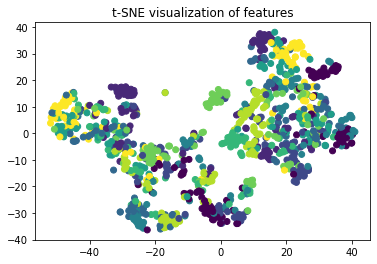

In [39]:

# Function to get the features from a model for a given dataset
def get_features(model, dataloader):
    model.eval()
    features = []
    targets = []
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            outputs = model(inputs)
            features.extend(outputs.cpu().numpy())
            targets.extend(labels.cpu().numpy())
    return np.array(features), np.array(targets)

# Get features from TCN model
tcn_features, tcn_targets = get_features(model_TCN, test_loader)

# Get features from RNN model
rnn_features, rnn_targets = get_features(model_rnn, test_loader)

# Concatenate the features and targets from both models
all_features = np.concatenate((tcn_features, rnn_features))
all_targets = np.concatenate((tcn_targets, rnn_targets))

# Apply t-SNE to reduce dimensionality to 2D
tsne = TSNE(n_components=2, random_state=42)
reduced_features = tsne.fit_transform(all_features)

# Plot the reduced features
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=all_targets)
plt.title('t-SNE visualization of features')
plt.show()


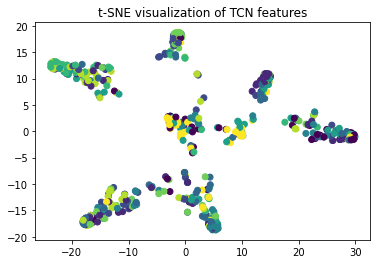

In [195]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Function to get the features from a model for a given dataset
def get_features2(model, dataloader):
    model.eval()
    features = []
    targets = []
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            outputs = model(inputs,use_lastlayer=True)
            features.extend(outputs.cpu().numpy())
            targets.extend(labels.cpu().numpy())
    return np.array(features), np.array(targets)

# Get features from TCN model
tcn_features, tcn_targets = get_features2(model_TCN, test_loader)

# Apply t-SNE to reduce dimensionality to 2D
tsne = TSNE(n_components=2, random_state=42)
reduced_features = tsne.fit_transform(tcn_features)

# Plot the reduced features
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=tcn_targets)
plt.title('t-SNE visualization of TCN features')
plt.show()

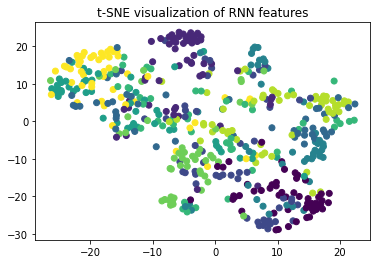

In [196]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Function to get the features from a model for a given dataset
def get_features(model, dataloader):
    model.eval()
    features = []
    targets = []
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            outputs = model(inputs)
            features.extend(outputs.cpu().numpy())
            targets.extend(labels.cpu().numpy())
    return np.array(features), np.array(targets)

# Get features from RNN model
rnn_features, rnn_targets = get_features(model_rnn, test_loader)

# Apply t-SNE to reduce dimensionality to 2D
tsne = TSNE(n_components=2, random_state=42)
reduced_features = tsne.fit_transform(rnn_features)

# Plot the reduced features
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=rnn_targets)
plt.title('t-SNE visualization of RNN features')
plt.show()

Bootstrapping

In [40]:
tcn_test_cr=test(model_TCN,test_loader)
rnn_test_cr = test(model_rnn, test_loader)

Test Loss: 0.134, Test Acc: 0.439
Test confusion matrix:
[[30  0  3  0  1  6  2  5  1  5]
 [ 0 23  1  2  0  6 21  1  0  1]
 [ 0  0 15  1  0  1 23 10  3  1]
 [ 0  2  3 10  0  0 10  5  6 10]
 [14  2  1  2  3 12  3  5  3  1]
 [ 0  2  0  0  3 14 18  3  1  9]
 [ 1  0  0  2  0  0 37  3  3  0]
 [ 0  0  2  1  0  3  3 35  1  2]
 [ 0  0  0  0  0  0 28  0 26  2]
 [ 0  1  1  1  1  6  8  3  1 28]]
Test classification report:
              precision    recall  f1-score   support

           0       0.67      0.57      0.61        53
           1       0.77      0.42      0.54        55
           2       0.58      0.28      0.38        54
           3       0.53      0.22      0.31        46
           4       0.38      0.07      0.11        46
           5       0.29      0.28      0.29        50
           6       0.24      0.80      0.37        46
           7       0.50      0.74      0.60        47
           8       0.58      0.46      0.51        56
           9       0.47      0.56      0.51

In [41]:
# Define the F1 scores for each model
report_lines_base = test_classification_report.split('\n')
report_lines_rnn = rnn_test_cr.split('\n')
report_lines_tcn = tcn_test_cr.split('\n')
model_base_f1 = [float(report_lines_base[i].split()[-2]) for i in range(2, 12)]
model_rnn_f1 = [float(report_lines_rnn[i].split()[-2]) for i in range(2, 12)]
model_tcn_f1 = [float(report_lines_tcn[i].split()[-2]) for i in range(2, 12)]

# Define the number of bootstrap samples to generate
n_samples = 10000

# Define a function to compute the difference in F1 score between two specific F1 scores
def diff_f1(f1_1, f1_2):
    return f1_1 - f1_2

# Compute the differences in F1 score for each pair of models
diff_base_rnn = diff_f1(model_base_f1[0], model_rnn_f1[0])
diff_base_tcn = diff_f1(model_base_f1[0], model_tcn_f1[0])
diff_rnn_tcn = diff_f1(model_rnn_f1[0], model_tcn_f1[0])

# Generate multiple bootstrap samples and compute the differences in F1 score for each sample
diffs_base_rnn = np.zeros(n_samples)
diffs_base_tcn = np.zeros(n_samples)
diffs_rnn_tcn = np.zeros(n_samples)

for i in range(n_samples):
    # Generate a new sample by randomly sampling with replacement from the original dataset
    y_true_sample = np.random.choice([0, 1], size=len(y_test_1), replace=True)
    model_base_sample = np.random.choice([0, 1], size=len(y_test_1), replace=True)
    model_rnn_sample = np.random.choice([0, 1], size=len(y_test), replace=True)
    model_tcn_sample = np.random.choice([0, 1], size=len(y_test), replace=True)

    # Compute the F1 scores for each model using the new sample
    model_base_f1_sample = f1_score(y_true_sample, model_base_sample)
    model_rnn_f1_sample = f1_score(y_true_sample, model_rnn_sample)
    model_tcn_f1_sample = f1_score(y_true_sample, model_tcn_sample)

    # Compute the differences in F1 score for each pair of models using the new sample
    diffs_base_rnn[i] = diff_f1(model_base_f1_sample, model_rnn_f1_sample)
    diffs_base_tcn[i] = diff_f1(model_base_f1_sample, model_tcn_f1_sample)
    diffs_rnn_tcn[i] = diff_f1(model_rnn_f1_sample, model_tcn_f1_sample)

# Compute the p-values for each pair of models based on the bootstrap samples

p_value_rnn_tcn = np.mean(diffs_rnn_tcn >= diff_rnn_tcn)
p_value_base_rnn = np.mean(diffs_base_rnn >= diff_base_rnn)
p_value_base_tcn = np.mean(diffs_base_tcn >= diff_base_tcn)


# Print the p-value and whether the difference is significant or not
print("p-value for difference between RNN and TCN models:", p_value_rnn_tcn)
print("p-value for difference between baseline and RNN models:", p_value_base_rnn)
print("p-value for difference between baseline and TCN models:", p_value_base_tcn)

if p_value_rnn_tcn < 0.05:
    print("The difference between the F1 scores of the RNN and TCN models is statistically significant.")
else:
    print("The difference between the F1 scores of the RNN and TCN models is not statistically significant.")

if p_value_base_rnn < 0.05:
    print("The difference between the F1 scores of the baseline and RNN models is statistically significant.")
else:
    print("The difference between the F1 scores of the baseline and RNN models is not statistically significant.")

if p_value_base_tcn < 0.05:
    print("The difference between the F1 scores of the baseline and TCN models is statistically significant.")
else:
    print("The difference between the F1 scores of the baseline and TCN models is not statistically significant.")

p-value for difference between RNN and TCN models: 0.0429
p-value for difference between baseline and RNN models: 0.6121
p-value for difference between baseline and TCN models: 0.0765
The difference between the F1 scores of the RNN and TCN models is statistically significant.
The difference between the F1 scores of the baseline and RNN models is not statistically significant.
The difference between the F1 scores of the baseline and TCN models is not statistically significant.


## Task III (Open Ended)
1. Consider the case where we have speech data from a single speaker (e.g., george). Train your models on this subset of the data. What do you observe? How does this affect the model performance?

2. Even though a model is trained on a single speaker, we would like the model to generalizes to any speaker. To this end, one can use data augmentation techniques to artificially create more samples for each class. Some of these augmentations can be applied on the spectrogram (e.g., SpecAugment https://ai.googleblog.com/2019/04/specaugment-new-data-augmentation.html), and other can be applied on the raw waveform before creating the spectrogram such as pitch manipulation (https://github.com/facebookresearch/WavAugment). Explore the effect of one type of augmentation from each type. Report your observation and anaylze the confusion matrices.

3. Data augmentation techniques create different "views" of each training sample in a stochastic or determinstic approach. One can leaverage speech data augmentation to create views for training a neural network in a contrastive learning setting with margin-based objective function (for more info, read http://proceedings.mlr.press/v130/al-tahan21a/al-tahan21a.pdf). Implement at least one model using a contrastive loss based on different views of the training samples. Does this model improve over the model without contrastive learning? Report and discuss your observations. 

For more information on the contrastive learning framework, you can refer to this paper
https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=9226466

In [198]:
# Load metadata
sdr_df = pd.read_csv('SDR_metadata.tsv', sep='\t', header=0, index_col='Unnamed: 0')

# Load data for each audio file, downsample and extract mel-spectrogram features
def load_downsample_melspec(audio_file, sr=8000, num_mels=13, hop_length=80):
    signal, _ = librosa.load(audio_file, sr=sr)
    mel_features = extract_melspectrogram(signal,sr=8000, num_mels=13)
    return mel_features


max_length = 0
for _, row in sdr_df.iterrows():
    mel_spec = load_downsample_melspec(row['file'])
    if mel_spec.shape[1] > max_length:
        max_length = mel_spec.shape[1]

# Load data and labels for all files in the metadata
X = []
y = []
for _, row in sdr_df.iterrows():
    mel_features = load_downsample_melspec(row['file'])
    padded_mel_features = np.pad(mel_features, ((0, 0), (0, max_length - mel_features.shape[1])), mode='constant')
    X.append(padded_mel_features)
    y.append(row['label'])
speakers=["george"]
# Split data into train, dev, and test sets
train_indices = sdr_df[sdr_df['split'] == 'TRAIN']
train_indices= train_indices[train_indices['speaker'].isin(speakers)].index
dev_indices = sdr_df[sdr_df['split'] == 'DEV'].index
test_indices = sdr_df[sdr_df['split'] == 'TEST'].index

X_train = [X[i] for i in train_indices]
y_train = [y[i] for i in train_indices]

X_dev = [X[i] for i in dev_indices]
y_dev = [y[i] for i in dev_indices]

X_test = [X[i] for i in test_indices]
y_test = [y[i] for i in test_indices]
# Convert data to PyTorch tensors
X_train_onedata = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)

X_dev = torch.tensor(X_dev, dtype=torch.float32)
y_dev = torch.tensor(y_dev, dtype=torch.long)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)


X_train_onedata.shape

torch.Size([500, 13, 229])

In [157]:
train_loaderone,dev_loaderone,test_loaderone=loader(X_train_onedata,y_train,X_dev,y_dev,X_test,y_test)


In [158]:
modelone = TCN(input_size, output_size, num_channels=[64, 64, 64], kernel_size=3,dropout=0.2)
modelonernn=RNNModel(input_size, 60, 2, output_size, 0.2)

In [159]:
train_model(modelone,train_loaderone,num_epochstcn,learning_ratetcn)
test_one=test(modelone,test_loaderone)


Epoch 1/50, Train Loss: 2.210Train Acc: 0.236
Epoch 2/50, Train Loss: 1.715Train Acc: 0.456
Epoch 3/50, Train Loss: 1.463Train Acc: 0.556
Epoch 4/50, Train Loss: 1.278Train Acc: 0.626
Epoch 5/50, Train Loss: 1.086Train Acc: 0.686
Epoch 6/50, Train Loss: 0.961Train Acc: 0.754
Epoch 7/50, Train Loss: 0.875Train Acc: 0.774
Epoch 8/50, Train Loss: 0.772Train Acc: 0.814
Epoch 9/50, Train Loss: 0.698Train Acc: 0.814
Epoch 10/50, Train Loss: 0.626Train Acc: 0.838
Epoch 11/50, Train Loss: 0.571Train Acc: 0.844
Epoch 12/50, Train Loss: 0.531Train Acc: 0.870
Epoch 13/50, Train Loss: 0.531Train Acc: 0.876
Epoch 14/50, Train Loss: 0.469Train Acc: 0.882
Epoch 15/50, Train Loss: 0.440Train Acc: 0.894
Epoch 16/50, Train Loss: 0.391Train Acc: 0.902
Epoch 17/50, Train Loss: 0.376Train Acc: 0.910
Epoch 18/50, Train Loss: 0.356Train Acc: 0.914
Epoch 19/50, Train Loss: 0.316Train Acc: 0.934
Epoch 20/50, Train Loss: 0.279Train Acc: 0.934
Epoch 21/50, Train Loss: 0.274Train Acc: 0.936
Epoch 22/50, Train Los

In [160]:
train_model(modelonernn,train_loaderone,num_epochstcn,learning_ratetcn)
test_one=test(modelonernn,test_loaderone)

Epoch 1/50, Train Loss: 2.235Train Acc: 0.174
Epoch 2/50, Train Loss: 2.027Train Acc: 0.310
Epoch 3/50, Train Loss: 1.876Train Acc: 0.430
Epoch 4/50, Train Loss: 1.738Train Acc: 0.506
Epoch 5/50, Train Loss: 1.581Train Acc: 0.578
Epoch 6/50, Train Loss: 1.399Train Acc: 0.644
Epoch 7/50, Train Loss: 1.208Train Acc: 0.692
Epoch 8/50, Train Loss: 1.030Train Acc: 0.772
Epoch 9/50, Train Loss: 0.879Train Acc: 0.794
Epoch 10/50, Train Loss: 0.736Train Acc: 0.834
Epoch 11/50, Train Loss: 0.635Train Acc: 0.868
Epoch 12/50, Train Loss: 0.538Train Acc: 0.906
Epoch 13/50, Train Loss: 0.483Train Acc: 0.908
Epoch 14/50, Train Loss: 0.412Train Acc: 0.920
Epoch 15/50, Train Loss: 0.371Train Acc: 0.928
Epoch 16/50, Train Loss: 0.335Train Acc: 0.936
Epoch 17/50, Train Loss: 0.317Train Acc: 0.934
Epoch 18/50, Train Loss: 0.274Train Acc: 0.946
Epoch 19/50, Train Loss: 0.239Train Acc: 0.950
Epoch 20/50, Train Loss: 0.204Train Acc: 0.970
Epoch 21/50, Train Loss: 0.189Train Acc: 0.962
Epoch 22/50, Train Los

From this we can observe that when we train both our models on training data with only one speaker both the models overfit the training data with RNN model acheving training accuracy of 1.0 and TCN with 0.990 but the performance on the testing data decreased in both cases with RNN acheiving a test accuracy of 0.306 and 0.219 for RNN and TCN respectively

# Frequency masking

In [199]:
# Load metadata
sdr_df = pd.read_csv('SDR_metadata.tsv', sep='\t', header=0, index_col='Unnamed: 0')

# Load data for each audio file, downsample and extract mel-spectrogram features
def load_downsample_melspec(audio_file, sr=8000, num_mels=13, hop_length=80):
    signal, _ = librosa.load(audio_file, sr=sr)
    mel_features = extract_melspectrogram(signal,sr=8000, num_mels=13)
    return mel_features


max_length = 0
for _, row in sdr_df.iterrows():
    mel_spec = load_downsample_melspec(row['file'])
    if mel_spec.shape[1] > max_length:
        max_length = mel_spec.shape[1]

# Load data and labels for all files in the metadata
X = []
y = []
for _, row in sdr_df.iterrows():
    mel_features = load_downsample_melspec(row['file'])
    padded_mel_features = np.pad(mel_features, ((0, 0), (0, max_length - mel_features.shape[1])), mode='constant')
    X.append(padded_mel_features)
    y.append(row['label'])
speakers=["george"]
# Split data into train, dev, and test sets
train_indices = sdr_df[sdr_df['split'] == 'TRAIN']
train_indices= train_indices[train_indices['speaker'].isin(speakers)].index
dev_indices = sdr_df[sdr_df['split'] == 'DEV'].index
test_indices = sdr_df[sdr_df['split'] == 'TEST'].index

X_train = [X[i] for i in train_indices]
y_train = [y[i] for i in train_indices]

X_dev = [X[i] for i in dev_indices]
y_dev = [y[i] for i in dev_indices]

X_test = [X[i] for i in test_indices]
y_test = [y[i] for i in test_indices]

In [200]:
def apply_frequency_masking(spec, num_masks=1, freq_mask_param=10):
    
    spec = spec.copy()
    for i in range(num_masks):
        f = random.randint(0, freq_mask_param)
        f0 = random.randint(0, spec.shape[0] - f)
        spec[f0:f0+f, :] = 0
    return spec

X_train_augmented = []
y_train_augmented = []

for spec, label in zip(X_train, y_train):
    for i in range(3):  # Generate 3 augmented samples for each original sample
        spec_augmented = apply_frequency_masking(spec)
        X_train_augmented.append(spec_augmented)
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)


In [205]:
X_train_oneaug = torch.tensor(X_train_augmented, dtype=torch.float32)

In [164]:
y_train_oneaug=torch.tensor(y_train_augmented, dtype=torch.long)

X_dev = torch.tensor(X_dev, dtype=torch.float32)
y_dev = torch.tensor(y_dev, dtype=torch.long)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

In [165]:
train_loaderfre,dev_loaderfre,test_loaderfre=loader(X_train_oneaug,y_train_oneaug,X_dev,y_dev,X_test,y_test)

In [166]:
modelfr = TCN(input_size, output_size, num_channels=[64, 64, 64], kernel_size=3,dropout=0.2)
modelfrrnn=RNNModel(input_size, 60, 2, output_size, 0.2)

In [167]:
train_model(modelfr,train_loaderfre,num_epochstcn,learning_ratetcn)

Epoch 1/50, Train Loss: 1.974Train Acc: 0.328
Epoch 2/50, Train Loss: 1.457Train Acc: 0.527
Epoch 3/50, Train Loss: 1.179Train Acc: 0.632
Epoch 4/50, Train Loss: 0.999Train Acc: 0.702
Epoch 5/50, Train Loss: 0.873Train Acc: 0.717
Epoch 6/50, Train Loss: 0.724Train Acc: 0.769
Epoch 7/50, Train Loss: 0.665Train Acc: 0.785
Epoch 8/50, Train Loss: 0.552Train Acc: 0.827
Epoch 9/50, Train Loss: 0.501Train Acc: 0.848
Epoch 10/50, Train Loss: 0.463Train Acc: 0.854
Epoch 11/50, Train Loss: 0.462Train Acc: 0.855
Epoch 12/50, Train Loss: 0.404Train Acc: 0.877
Epoch 13/50, Train Loss: 0.375Train Acc: 0.885
Epoch 14/50, Train Loss: 0.343Train Acc: 0.895
Epoch 15/50, Train Loss: 0.303Train Acc: 0.903
Epoch 16/50, Train Loss: 0.307Train Acc: 0.903
Epoch 17/50, Train Loss: 0.277Train Acc: 0.913
Epoch 18/50, Train Loss: 0.245Train Acc: 0.927
Epoch 19/50, Train Loss: 0.245Train Acc: 0.917
Epoch 20/50, Train Loss: 0.233Train Acc: 0.931
Epoch 21/50, Train Loss: 0.207Train Acc: 0.941
Epoch 22/50, Train Los

In [168]:
test_fr=test(modelfr,test_loaderfre)

Test Loss: 0.215, Test Acc: 0.207
Test confusion matrix:
[[11 16  6  0  4  7  4  4  0  1]
 [ 6 14  2  5  8  3 17  0  0  0]
 [ 4  5  2 10  6  6 19  1  1  0]
 [ 5  9  7  8  7  0  7  2  0  1]
 [ 3 10  2  3 15  2 10  0  1  0]
 [10 17  1  2  2  6  6  4  0  2]
 [ 6  3  0  0  4  1 28  4  0  0]
 [ 7  1  2  1  8  8  8  9  1  2]
 [ 2  7  7  5  8  3 21  2  1  0]
 [ 5 17  0  2  6  8  1  1  0 10]]
Test classification report:
              precision    recall  f1-score   support

           0       0.19      0.21      0.20        53
           1       0.14      0.25      0.18        55
           2       0.07      0.04      0.05        54
           3       0.22      0.17      0.20        46
           4       0.22      0.33      0.26        46
           5       0.14      0.12      0.13        50
           6       0.23      0.61      0.34        46
           7       0.33      0.19      0.24        47
           8       0.25      0.02      0.03        56
           9       0.62      0.20      0.30

From this report we can see that TCN acheives a good training accuracy while on the test set it acheives an accuracy of 0.207
We can conclude from this that the TCN model is overfitting to the training data

In [169]:
train_model(modelfrrnn,train_loaderfre,num_epochstcn,learning_ratetcn)
test_fr=test(modelfrrnn,test_loaderfre)

Epoch 1/50, Train Loss: 2.105Train Acc: 0.260
Epoch 2/50, Train Loss: 1.851Train Acc: 0.396
Epoch 3/50, Train Loss: 1.672Train Acc: 0.493
Epoch 4/50, Train Loss: 1.515Train Acc: 0.529
Epoch 5/50, Train Loss: 1.391Train Acc: 0.579
Epoch 6/50, Train Loss: 1.251Train Acc: 0.627
Epoch 7/50, Train Loss: 1.160Train Acc: 0.655
Epoch 8/50, Train Loss: 1.064Train Acc: 0.691
Epoch 9/50, Train Loss: 0.967Train Acc: 0.722
Epoch 10/50, Train Loss: 0.886Train Acc: 0.743
Epoch 11/50, Train Loss: 0.844Train Acc: 0.743
Epoch 12/50, Train Loss: 0.766Train Acc: 0.781
Epoch 13/50, Train Loss: 0.728Train Acc: 0.781
Epoch 14/50, Train Loss: 0.677Train Acc: 0.799
Epoch 15/50, Train Loss: 0.633Train Acc: 0.810
Epoch 16/50, Train Loss: 0.573Train Acc: 0.821
Epoch 17/50, Train Loss: 0.558Train Acc: 0.845
Epoch 18/50, Train Loss: 0.520Train Acc: 0.847
Epoch 19/50, Train Loss: 0.497Train Acc: 0.857
Epoch 20/50, Train Loss: 0.465Train Acc: 0.864
Epoch 21/50, Train Loss: 0.426Train Acc: 0.874
Epoch 22/50, Train Los

From this report we can see that RNN acheives a good training accuracy while on the test set it acheives an accuracy of 0.225
We can conclude from this that the RNN model is overfitting to the training data

In [183]:
# Load metadata
sdr_df = pd.read_csv('SDR_metadata.tsv', sep='\t', header=0, index_col='Unnamed: 0')

# Load data for each audio file, downsample and extract mel-spectrogram features
def load_downsample_melspec(audio_file, sr=8000, num_mels=13, hop_length=80, pitch_shift=None):
    signal, _ = librosa.load(audio_file, sr=sr)
    if pitch_shift:
        signal = librosa.effects.pitch_shift(signal, sr, n_steps=pitch_shift)
    mel_features = extract_melspectrogram(signal,sr=8000, num_mels=13)
    return mel_features


max_length = 0
for _, row in sdr_df.iterrows():
    mel_spec = load_downsample_melspec(row['file'])
    if mel_spec.shape[1] > max_length:
        max_length = mel_spec.shape[1]

# Load data and labels for all files in the metadata
X = []
y = []
for _, row in sdr_df.iterrows():
    if row['split'] == 'TRAIN':
        mel_features = load_downsample_melspec(row['file'], pitch_shift=2)
    else:
        mel_features = load_downsample_melspec(row['file'])
    padded_mel_features = np.pad(mel_features, ((0, 0), (0, max_length - mel_features.shape[1])), mode='constant')
    X.append(padded_mel_features)
    y.append(row['label'])

speakers=["george"]
# Split data into train, dev, and test sets
train_indices_p = sdr_df[sdr_df['split'] == 'TRAIN']
train_indices_p= train_indices_p[train_indices_p['speaker'].isin(speakers)].index
dev_indices = sdr_df[sdr_df['split'] == 'DEV'].index
test_indices = sdr_df[sdr_df['split'] == 'TEST'].index


In [184]:
X_train = [X[i] for i in train_indices_p]
y_train = [y[i] for i in train_indices_p]

X_dev = [X[i] for i in dev_indices]
y_dev = [y[i] for i in dev_indices]

X_test = [X[i] for i in test_indices]
y_test = [y[i] for i in test_indices]
# Convert data to PyTorch tensors
X_train_p = torch.tensor(X_train, dtype=torch.float32)
y_train_p = torch.tensor(y_train, dtype=torch.long)

X_dev = torch.tensor(X_dev, dtype=torch.float32)
y_dev = torch.tensor(y_dev, dtype=torch.long)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)




In [185]:
train_loaderp,dev_loaderp,test_loaderp=loader(X_train_p,y_train_p,X_dev,y_dev,X_test,y_test)

In [186]:
modelp = TCN(input_size, output_size, num_channels=[64, 64, 64], kernel_size=3,dropout=0.2)
modelrnnp=RNNModel(input_size, 60, 2, output_size, 0.2)

In [187]:
train_model(modelp,train_loaderp,num_epochstcn,learning_ratetcn)

Epoch 1/50, Train Loss: 2.203Train Acc: 0.270
Epoch 2/50, Train Loss: 1.798Train Acc: 0.398
Epoch 3/50, Train Loss: 1.609Train Acc: 0.478
Epoch 4/50, Train Loss: 1.463Train Acc: 0.576
Epoch 5/50, Train Loss: 1.322Train Acc: 0.604
Epoch 6/50, Train Loss: 1.198Train Acc: 0.658
Epoch 7/50, Train Loss: 1.068Train Acc: 0.718
Epoch 8/50, Train Loss: 0.998Train Acc: 0.732
Epoch 9/50, Train Loss: 0.862Train Acc: 0.790
Epoch 10/50, Train Loss: 0.784Train Acc: 0.818
Epoch 11/50, Train Loss: 0.692Train Acc: 0.820
Epoch 12/50, Train Loss: 0.680Train Acc: 0.826
Epoch 13/50, Train Loss: 0.606Train Acc: 0.836
Epoch 14/50, Train Loss: 0.540Train Acc: 0.866
Epoch 15/50, Train Loss: 0.505Train Acc: 0.870
Epoch 16/50, Train Loss: 0.467Train Acc: 0.878
Epoch 17/50, Train Loss: 0.424Train Acc: 0.890
Epoch 18/50, Train Loss: 0.415Train Acc: 0.896
Epoch 19/50, Train Loss: 0.340Train Acc: 0.928
Epoch 20/50, Train Loss: 0.358Train Acc: 0.906
Epoch 21/50, Train Loss: 0.334Train Acc: 0.926
Epoch 22/50, Train Los

In [188]:
test_p=test(modelp,test_loaderp)

Test Loss: 0.205, Test Acc: 0.207
Test confusion matrix:
[[24  0  0  3  5  3  8 10  0  0]
 [ 4  5  0 16  0  0 26  2  2  0]
 [ 0  1  3  2  1  0 33 11  2  1]
 [15  2  0 10  4  0 11  3  0  1]
 [ 9  0  0  9  6  2 10 10  0  0]
 [ 9  5  0  5  0  3 21  3  2  2]
 [ 3  2  0  6  1  0 28  5  0  1]
 [ 7  0  1  3  5  0 12 17  2  0]
 [ 9  0  0  9  0  0 32  4  1  1]
 [ 3  5  0  3  3  3 14 12  0  7]]
Test classification report:
              precision    recall  f1-score   support

           0       0.29      0.45      0.35        53
           1       0.25      0.09      0.13        55
           2       0.75      0.06      0.10        54
           3       0.15      0.22      0.18        46
           4       0.24      0.13      0.17        46
           5       0.27      0.06      0.10        50
           6       0.14      0.61      0.23        46
           7       0.22      0.36      0.27        47
           8       0.11      0.02      0.03        56
           9       0.54      0.14      0.22

In [189]:
train_model(modelrnnp,train_loaderp,num_epochstcn,learning_ratetcn)
test(modelrnnp,test_loader)

Epoch 1/50, Train Loss: 2.192Train Acc: 0.216
Epoch 2/50, Train Loss: 2.029Train Acc: 0.306
Epoch 3/50, Train Loss: 1.925Train Acc: 0.396
Epoch 4/50, Train Loss: 1.767Train Acc: 0.466
Epoch 5/50, Train Loss: 1.516Train Acc: 0.578
Epoch 6/50, Train Loss: 1.273Train Acc: 0.670
Epoch 7/50, Train Loss: 1.088Train Acc: 0.710
Epoch 8/50, Train Loss: 0.930Train Acc: 0.760
Epoch 9/50, Train Loss: 0.798Train Acc: 0.806
Epoch 10/50, Train Loss: 0.690Train Acc: 0.844
Epoch 11/50, Train Loss: 0.625Train Acc: 0.848
Epoch 12/50, Train Loss: 0.524Train Acc: 0.896
Epoch 13/50, Train Loss: 0.445Train Acc: 0.898
Epoch 14/50, Train Loss: 0.394Train Acc: 0.918
Epoch 15/50, Train Loss: 0.338Train Acc: 0.930
Epoch 16/50, Train Loss: 0.311Train Acc: 0.922
Epoch 17/50, Train Loss: 0.271Train Acc: 0.952
Epoch 18/50, Train Loss: 0.247Train Acc: 0.960
Epoch 19/50, Train Loss: 0.234Train Acc: 0.954
Epoch 20/50, Train Loss: 0.217Train Acc: 0.964
Epoch 21/50, Train Loss: 0.187Train Acc: 0.966
Epoch 22/50, Train Los

'              precision    recall  f1-score   support\n\n           0       0.37      0.47      0.41        53\n           1       0.20      0.31      0.24        55\n           2       0.29      0.07      0.12        54\n           3       0.31      0.24      0.27        46\n           4       0.08      0.02      0.03        46\n           5       0.23      0.14      0.17        50\n           6       0.11      0.33      0.16        46\n           7       0.16      0.34      0.21        47\n           8       0.25      0.02      0.03        56\n           9       0.38      0.10      0.16        50\n\n    accuracy                           0.20       503\n   macro avg       0.24      0.20      0.18       503\nweighted avg       0.24      0.20      0.18       503\n'

Constrastive Learning

In [190]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

class ContrastiveDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        x1 = self.X[idx]
        if self.transform:
            x2 = self.transform(x1)
        else:
            x2 = x1
        return x1, x2, self.y[idx]
    
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        
    def forward(self, x1, x2, y):
        dist = F.pairwise_distance(x1, x2)
        loss = torch.mean((y * dist**2) + ((1 - y) * F.relu(self.margin - dist)**2))
        return loss
    

def augment(x):
    x = apply_frequency_masking(x)
    return x

# Create contrastive dataset
train_dataset = ContrastiveDataset(X_train, y_train, transform=augment)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Create model and optimizer
modelcontra = TCN(input_size=229, output_size=2, num_channels=[32]*5, kernel_size=3, dropout=0.2)
optimizer = Adam(modelcontra.parameters(), lr=0.001)

# Train model
criterion = ContrastiveLoss(margin=1.0)
for epoch in range(50):
    train_loss = 0.0
    for x1, x2, y in train_loader:
        optimizer.zero_grad()
        out1 = modelcontra(x1)
        out2 = modelcontra(x2)
        loss = criterion(out1, out2, y.float())
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * len(x1)
    train_loss /= len(train_dataset)
    
  
    
    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}")


Epoch 1: Train Loss=1.9976
Epoch 2: Train Loss=0.8222
Epoch 3: Train Loss=-0.0234
Epoch 4: Train Loss=-0.8923
Epoch 5: Train Loss=-1.2639
Epoch 6: Train Loss=-1.5666
Epoch 7: Train Loss=-2.0405
Epoch 8: Train Loss=-2.2692
Epoch 9: Train Loss=-2.5132
Epoch 10: Train Loss=-2.7047
Epoch 11: Train Loss=-2.7901
Epoch 12: Train Loss=-2.8538
Epoch 13: Train Loss=-2.9577
Epoch 14: Train Loss=-3.0099
Epoch 15: Train Loss=-3.0776
Epoch 16: Train Loss=-3.1692
Epoch 17: Train Loss=-3.1752
Epoch 18: Train Loss=-3.2043
Epoch 19: Train Loss=-3.2114
Epoch 20: Train Loss=-3.2702
Epoch 21: Train Loss=-3.2862
Epoch 22: Train Loss=-3.3374
Epoch 23: Train Loss=-3.3382
Epoch 24: Train Loss=-3.3498
Epoch 25: Train Loss=-3.3425
Epoch 26: Train Loss=-3.3724
Epoch 27: Train Loss=-3.3571
Epoch 28: Train Loss=-3.3910
Epoch 29: Train Loss=-3.3906
Epoch 30: Train Loss=-3.4018
Epoch 31: Train Loss=-3.3970
Epoch 32: Train Loss=-3.4204
Epoch 33: Train Loss=-3.4115
Epoch 34: Train Loss=-3.4280
Epoch 35: Train Loss=-3.4

In [191]:
total_correct = 0
total_samples = 0


test_dataset = ContrastiveDataset(X_test, y_test, transform=None)
modelcontra.eval()
with torch.no_grad():
    for x1, y in test_loader:
        outputs = modelcontra(x1)
        predicted_labels = torch.argmax(outputs, dim=1)
        total_correct += (predicted_labels == y).sum().item()
        total_samples += y.shape[0]
test_acc=total_correct/total_samples
test_acc

0.10934393638170974

In [192]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

class ContrastiveDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        x1 = self.X[idx]
        if self.transform:
            x2 = self.transform(x1)
        else:
            x2 = x1
        return x1, x2, self.y[idx]
    
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        
    def forward(self, x1, x2, y):
        dist = F.pairwise_distance(x1, x2)
        loss = torch.mean((y * dist**2) + ((1 - y) * F.relu(self.margin - dist)**2))
        return loss
    

def augment(x):
    x = apply_frequency_masking(x)
    return x

# Create contrastive dataset
train_dataset = ContrastiveDataset(X_train, y_train, transform=augment)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Create model and optimizer
modelrnncontra=RNNModel(input_size, 60, 2, output_size, 0.2)
optimizer = Adam(modelrnncontra.parameters(), lr=0.001)

# Train model
criterion = ContrastiveLoss(margin=1.0)
for epoch in range(50):
    train_loss = 0.0
    for x1, x2, y in train_loader:
        optimizer.zero_grad()
        out1 = modelrnncontra(x1)
        out2 = modelrnncontra(x2)
        loss = criterion(out1, out2, y.float())
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * len(x1)
    train_loss /= len(train_dataset)
    
  
    
    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}")


Epoch 1: Train Loss=-1.3753
Epoch 2: Train Loss=-2.4246
Epoch 3: Train Loss=-2.9760
Epoch 4: Train Loss=-3.2207
Epoch 5: Train Loss=-3.3518
Epoch 6: Train Loss=-3.4066
Epoch 7: Train Loss=-3.4431
Epoch 8: Train Loss=-3.4602
Epoch 9: Train Loss=-3.4711
Epoch 10: Train Loss=-3.4760
Epoch 11: Train Loss=-3.4804
Epoch 12: Train Loss=-3.4835
Epoch 13: Train Loss=-3.4860
Epoch 14: Train Loss=-3.4878
Epoch 15: Train Loss=-3.4893
Epoch 16: Train Loss=-3.4905
Epoch 17: Train Loss=-3.4913
Epoch 18: Train Loss=-3.4919
Epoch 19: Train Loss=-3.4924
Epoch 20: Train Loss=-3.4932
Epoch 21: Train Loss=-3.4938
Epoch 22: Train Loss=-3.4943
Epoch 23: Train Loss=-3.4946
Epoch 24: Train Loss=-3.4949
Epoch 25: Train Loss=-3.4953
Epoch 26: Train Loss=-3.4956
Epoch 27: Train Loss=-3.4957
Epoch 28: Train Loss=-3.4960
Epoch 29: Train Loss=-3.4963
Epoch 30: Train Loss=-3.4966
Epoch 31: Train Loss=-3.4965
Epoch 32: Train Loss=-3.4968
Epoch 33: Train Loss=-3.4969
Epoch 34: Train Loss=-3.4971
Epoch 35: Train Loss=-3

In [193]:
total_correct = 0
total_samples = 0


test_dataset = ContrastiveDataset(X_test, y_test, transform=None)
modelrnncontra.eval()
with torch.no_grad():
    for x1, y in test_loader:
        outputs = modelrnncontra(x1)
        predicted_labels = torch.argmax(outputs, dim=1)
        total_correct += (predicted_labels == y).sum().item()
        total_samples += y.shape[0]
test_acc=total_correct/total_samples
test_acc

0.09145129224652088